In [6]:
from statsmodels.tsa.arima_process import ArmaProcess 
from statsmodels.tsa.stattools import pacf, acf
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
import matplotlib.pyplot as plt
import numpy as np
import math
import pandas as pd
from pandas import Series
import random
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from scipy import eye, asarray, dot, sum, diag
from scipy.linalg import svd
from mpl_toolkits.basemap import Basemap
import matplotlib as mpl
from matplotlib import cm
from colorspacious import cspace_converter
from collections import OrderedDict
from netCDF4 import Dataset
from numpy import linspace
from numpy import meshgrid
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.stattools import grangercausalitytests

from climate_indices import indices,compute
from climate_indices.indices import Distribution

import PCA_functions as pf

from tigramite import plotting as tp
from tigramite.pcmci import PCMCI
from tigramite.independence_tests import ParCorr, CMIknn
import tigramite.data_processing as pp

from statsmodels.tsa.stattools import adfuller
from Data import Data
from datetime import datetime

from sklearn.manifold import TSNE, MDS, Isomap
from sklearn.cluster import AgglomerativeClustering, DBSCAN, KMeans

from mpl_toolkits.mplot3d import Axes3D

from scipy.cluster.hierarchy import dendrogram, linkage

from sklearn.cluster import KMeans

import itertools
from collections import Counter
import pickle

from numpy import linalg as LA

from scipy import stats
from scipy.special import inv_boxcox

import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from sklearn import metrics

import pulp as p
import re

In [2]:
def phase_averaging(data,freq = 12):
    N = len(data)
    temp = data
    result = np.zeros(N)
    averages = np.zeros(freq)
    for j in range(freq):
        Idx = np.arange(j,N,freq)
        averages[j] = temp[Idx].mean()
        result[Idx] = (temp[Idx] - temp[Idx].mean())/temp[Idx].std()
    return(result, averages)

In [3]:
def load_obj(name):
    with open(name + '.pkl', 'rb') as f:
        return pickle.load(f)
class_dic = load_obj("class_dic")

def neighbour_vote(df,lat,lon):
    shift = [[-0.25,0,0.25],[-0.25,0,0.25]]
    shift_list = []
    for element in itertools.product(*shift):
        shift_list.append(element)
    shift_list.remove((0,0))
    result = []
    for x,y in shift_list:
        if not df[(df.lats == (lat + y)) & (df.lons == (lon + x))].clusters.values.size == 0:           
            result.append(np.asscalar(df[(df.lats == (lat + y)) & (df.lons == (lon + x))].clusters.values))
        else:
            result.append(-1)   
            
    return(np.array(result))

def neighbour_average(pre_list,result,lon,lat):
    shift = [[-0.25,0,0.25],[-0.25,0,0.25]]
    shift_list = []
    for element in itertools.product(*shift):
        shift_list.append(element)
    shift_list.remove((0,0))
    r = []
    for x,y in shift_list:
        if (lon + x,lat + y) in pre_list:
            j = pre_list.index((lon + x,lat + y))
            r.append(result.iloc[:,j].values)
        #else:
         #   print("NO")
          #  print(lon + x,lat + y)
           # r.append(np.zeros(817))   
    r = np.array(r)        
    return(np.average(r, axis=0))
    #return(r)

def neighbour_vote_class(dic,lat,lon):
    shift = [[-0.25,0.25],[-0.25,0.25]]
    shift_list = []
    for element in itertools.product(*shift):
        shift_list.append(element)
    #shift_list.remove((0,0))
    result = []
    for x,y in shift_list:
        if lon > 180: lon -= 360
        if (lat + y, lon + x) in class_dic.keys():
            result.append(class_dic[(lat + y, lon + x)])   
    return(np.array(result))

def fuzzify(x):
  # Add some "measurement error"" to each data point
    zero_idx = x==0
    x[zero_idx]+=0.005*np.random.uniform(0,1,1)[0]
    x[~zero_idx]+=0.005*np.random.uniform(-1,1,1)[0]
    return(x)
    
def transform(data):
    lambda_list = []
    n  = data.shape[1]
    N  = data.shape[0]
    data_transformed = np.zeros(data.shape)
    for i in range(n):
        x = fuzzify(pd.DataFrame(result[:,i]))[0].values
        data_transformed[:,i], lambda_ = stats.boxcox(x)
        lambda_list.append(lambda_)
    return(data_transformed, lambda_list)

In [4]:
def neighbour_vote(df,lat,lon):
    shift = [[-0.25,0,0.25],[-0.25,0,0.25]]
    shift_list = []
    for element in itertools.product(*shift):
        shift_list.append(element)
    shift_list.remove((0,0))
    result = []
    for x,y in shift_list:
        if not df[(df.lats == (lat + y)) & (df.lons == (lon + x))].clusters.values.size == 0:           
            result.append(np.asscalar(df[(df.lats == (lat + y)) & (df.lons == (lon + x))].clusters.values))
        else:
            result.append(-1)   
            
        
    return(np.array(result))

In [5]:
def neighbour_vote_class(dic,lat,lon):
    shift = [[-0.25,0.25],[-0.25,0.25]]
    shift_list = []
    for element in itertools.product(*shift):
        shift_list.append(element)
    #shift_list.remove((0,0))
    result = []
    for x,y in shift_list:
        if lon > 180: lon -= 360
        if (lat + y, lon + x) in class_dic.keys():
            result.append(class_dic[(lat + y, lon + x)])   
    return(np.array(result))

In [7]:
n_components = 15
level = 12
temporal_limits = {"time_min":datetime(1948, 1, 1, 0, 0),"time_max":datetime(2016, 1, 1, 0, 0) } 
spatial_limits = {"lon_min":-40,"lon_max":60,"lat_min":-40,"lat_max":40}

In [5]:
d = Data('GPCC_half.nc','precip',temporal_limits, missing_value=-9.969209968386869e+36)

result = d.get_data()
lon_list = d.get_lon_list()
lat_list = d.get_lat_list()
lon = d.get_lon()
lat = d.get_lat()

In [10]:
d = Data('air_daily_africa.nc','air', missing_value=-9.96921e+36)

result_air = d.get_data()
lon_list_air = d.get_lon_list()
lat_list_air = d.get_lat_list()
lon_air = d.get_lon()
lat_air = d.get_lat()

In [6]:
d = Data('air_monthly_mean_africa.nc','air', missing_value=-9.96921e+36)

result_air = d.get_data()
lon_list_air = d.get_lon_list()
lat_list_air = d.get_lat_list()
lon_air = d.get_lon()
lat_air = d.get_lat()

# Raw Data using matrix norm:

In [51]:
d = Data('GPCC_half.nc','precip',temporal_limits, missing_value=-9.969209968386869e+36)

result = d.get_data()
lon_list = d.get_lon_list()
lat_list = d.get_lat_list()
lon = d.get_lon()
lat = d.get_lat()

In [52]:
d = Data('air_monthly_mean_africa.nc','air', missing_value=-9.96921e+36)

result_air = d.get_data()
lon_list_air = d.get_lon_list()
lat_list_air = d.get_lat_list()
lon_air = d.get_lon()
lat_air = d.get_lat()

In [83]:
air_list = list(zip(lon_list_air,lat_list_air))

pre_list = list(zip(lon_list,lat_list))

clean_list = []
index = []
for i in range(len(air_list)):
    temp = neighbour_average(pre_list,pd.DataFrame(result),air_list[i][0], air_list[i][1])
    if temp.shape:
    #if not np.isnan(temp):
        clean_list.append(temp)
        index.append(i)
    #data[:,i,1] = np.squeeze(result_air[:,i])
    #data[:,i,0] = neighbour_average(pre_list,pd.DataFrame(result),air_list[i][0], air_list[i][1])

In [84]:
data = np.zeros((result_air.shape[0],len(clean_list),2))

for i in range(len(clean_list)):

    data[:,i,1] = np.squeeze(result_air[:,index[i]])
    data[:,i,0] = clean_list[i]

distance = np.zeros((data.shape[1],data.shape[1]))

for i in range(data.shape[1]):
    for j in range(data.shape[1]):
        distance[i,j] = LA.norm(data[:,i,:]-data[:,j,:])

In [85]:
clustering = AgglomerativeClustering(n_clusters=n_components,affinity="precomputed",linkage="complete").fit(distance)

In [86]:
clusters_air = np.zeros(len(lon_list_air))
clusters_air.fill(-1)

clusters_air[index] = clustering.labels_ 

index = np.argwhere(clusters_air == -1)

clusters_air = np.delete(clusters_air, index)
lat_list_air = np.delete(lat_list_air, index)
lon_list_air = np.delete(lon_list_air, index)

df_air = pd.DataFrame({"lons":lon_list_air,"lats":lat_list_air,"clusters":clusters_air})

lon_temp = df_air["lons"].values
lon_temp[lon_temp > 180] = lon_temp[lon_temp > 180] -360
df_air["lons"] = lon_temp

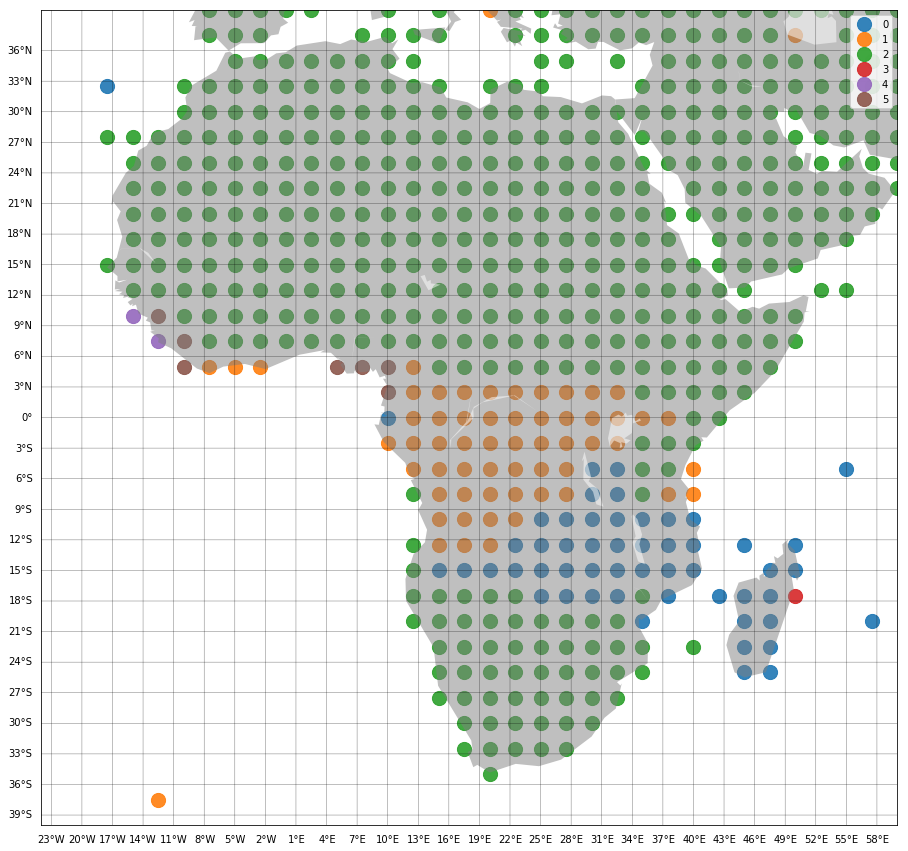

In [87]:
df_list = []
for j in range(len(set(clusters_air))):
    df_list.append(pd.DataFrame(columns=df_air.columns))

#lon = np.arange(-23.75,60.0,2.5)

fig, ax = plt.subplots(figsize=(30,15))
#fig = plt.figure(figsize=(30,15))
#ax = fig.add_subplot(111)
m = Basemap(llcrnrlon=-24, llcrnrlat=-40,urcrnrlon=60,urcrnrlat=40)
m.fillcontinents(color='grey', alpha=0.5)
m.drawparallels(np.arange(int(-39.75),int(39.75),3),labels=[1,0,0,0],linewidth=0.5)
m.drawmeridians(np.arange(int(-29.75),int(59.75),3),labels=[0,0,0,1],linewidth=0.5)
#m.drawcoastlines()
#colors = pf.random_color_1(n_components)

i = 0
for j in set(clusters_air):
    values = df_air["clusters"].values  
    Idx = np.where(values == j)[0]
    df_list[i] = df_air.iloc[Idx,:]
    df_list[i]["values"] = values[Idx]

    lons = df_list[i]["lons"].values
    lats = df_list[i]["lats"].values
    x,y = m(lons, lats)
    ax.scatter(x, y, alpha=0.9, s=200, label = i)
    i+=1

    
plt.legend()
plt.show()

# Raw Data using vector euclidean distance:

In [176]:
result_list_op = []

In [173]:
n_components = 4

In [177]:
for n_components in range(4,26):
    level = 12
    temporal_limits = {"time_min":datetime(1948, 1, 1, 0, 0),"time_max":datetime(2016, 1, 1, 0, 0) } 
    spatial_limits = {"lon_min":-40,"lon_max":60,"lat_min":-40,"lat_max":40}

    d = Data('GPCC_half.nc','precip',temporal_limits, missing_value=-9.96921e+36)

    result = d.get_data()
    lon_list = d.get_lon_list()
    lat_list = d.get_lat_list()
    lon = d.get_lon()
    lat = d.get_lat()

    d = Data('air_monthly_mean_africa.nc','air', missing_value=-9.96921e+36)

    result_air = d.get_data()
    lon_list_air = d.get_lon_list()
    lat_list_air = d.get_lat_list()
    lon_air = d.get_lon()
    lat_air = d.get_lat()

    #result = transform(result)

    air_list = list(zip(lon_list_air,lat_list_air))

    pre_list = list(zip(lon_list,lat_list))

    clean_list = []
    Idx = []
    for i in range(len(air_list)):
        temp = neighbour_average(pre_list,pd.DataFrame(result),air_list[i][0], air_list[i][1])
        if temp.shape:
        #if not np.isnan(temp):
            clean_list.append(temp)
            Idx.append(i)
        #data[:,i,1] = np.squeeze(result_air[:,i])
        #data[:,i,0] = neighbour_average(pre_list,pd.DataFrame(result),air_list[i][0], air_list[i][1])

    precipitation = np.array(clean_list)#/np.array(clean_list).std()
    precipitation = pd.DataFrame(np.transpose(precipitation))

    result_air = pd.DataFrame(result_air)
    temperature = result_air.iloc[:,Idx]

    #temperature = temperature/temperature.stack().std()

    precipitation.columns = temperature.columns

    combined_vertically = pd.concat([temperature,precipitation],ignore_index=True,sort=False, axis=0)

    clustering = AgglomerativeClustering(n_clusters=n_components).fit(combined_vertically.transpose())
    #clustering = KMeans(n_clusters=n_components).fit(combined_vertically.transpose())

    clusters_air = np.zeros(len(lon_list_air))
    clusters_air.fill(-1)

    clusters_air[Idx] = clustering.labels_ 

    index = np.argwhere(clusters_air == -1)

    clusters_air = np.delete(clusters_air, index)
    lat_list_air = np.delete(lat_list_air, index)
    lon_list_air = np.delete(lon_list_air, index)

    df_air = pd.DataFrame({"lons":lon_list_air,"lats":lat_list_air,"clusters":clusters_air})

    lon_temp = df_air["lons"].values
    lon_temp[lon_temp > 180] = lon_temp[lon_temp > 180] -360
    df_air["lons"] = lon_temp

    class_air = []
    for i in range(len(clusters_air)):
        r = neighbour_vote_class(df_air,lat_list_air[i],lon_list_air[i])  
        if r.size == 0:
            class_air.append('NAN')
        else:
            most_common,num_most_common = Counter(r).most_common(1)[0]
            class_air.append(most_common)

    df_class = pd.DataFrame({"lons":lon_list_air,"lats":lat_list_air,"clusters":class_air})

    lon_temp = df_class["lons"].values
    lon_temp[lon_temp > 180] = lon_temp[lon_temp > 180] -360
    df_class["lons"] = lon_temp

    similarity = np.zeros((len(set(clusters_air)),len(set(class_air))))

    values = df_air["clusters"].values
    class_values = df_class["clusters"].values

    count_i = 0 
    count_j = 0
    for i in set(clusters_air): 
        index = np.where(values == i)[0]
        for j in set(class_air):         
            class_Idx = np.where(class_values == j)[0]
            similarity[count_i,count_j] = len(np.intersect1d(index,class_Idx))
            count_j += 1
        count_j = 0    
        count_i += 1

    n = 18

    w = similarity

    if w.shape[0]<n:
        d = n - w.shape[0]
        w = np.r_[w, np.zeros((d,n))]

    prob = p.LpProblem("ClusterAssigment", p.LpMaximize)

    #Create a binary variable
    #It determines which edge should be included
    #And which one should be eliminated
    assign_vars = p.LpVariable.dicts("X",
                                     [(i, j) for i in range(n)
                                      for j in range(n)],
                                     0, 1, p.LpBinary)

    #Objective function
    #Maximizing the sum of weights of included links
    prob += p.lpSum(w[i,j] * assign_vars[i,j] for i in range(n) for j in range(n))

    #Constrains: There must be either one or zero link originating from a node
    for j in range(n):
        prob += p.lpSum(assign_vars[i,j] for i in range(n)) == 1

    #Constrains: There must be either one or zero link going to a node
    for i in range(n):
        prob += p.lpSum(assign_vars[i,j] for j in range(n)) == 1

    #Running the optimization
    prob.solve()


    #Converting the result to a numpy array
    result = np.zeros(w.shape)
    matching_points = 0
    for v in prob.variables():
        string  = str(v.name)
        r = re.findall(r"\w+",string)
        i = int(r[1])
        j = int(r[2][1:])
        if v.value() == 1: 
            matching_points += w[i,j]
        result[i,j] = v.value()



    #Percentage of matching points 
    n_points = np.sum(w)
    result_list_op.append(matching_points/n_points)

In [178]:
result_list_op

[0.523972602739726,
 0.5702054794520548,
 0.5753424657534246,
 0.547945205479452,
 0.5085616438356164,
 0.511986301369863,
 0.511986301369863,
 0.4931506849315068,
 0.4965753424657534,
 0.4965753424657534,
 0.5017123287671232,
 0.5,
 0.4914383561643836,
 0.488013698630137,
 0.488013698630137,
 0.488013698630137,
 0.488013698630137,
 0.488013698630137,
 0.4863013698630137,
 0.4863013698630137,
 0.4845890410958904,
 0.4914383561643836]

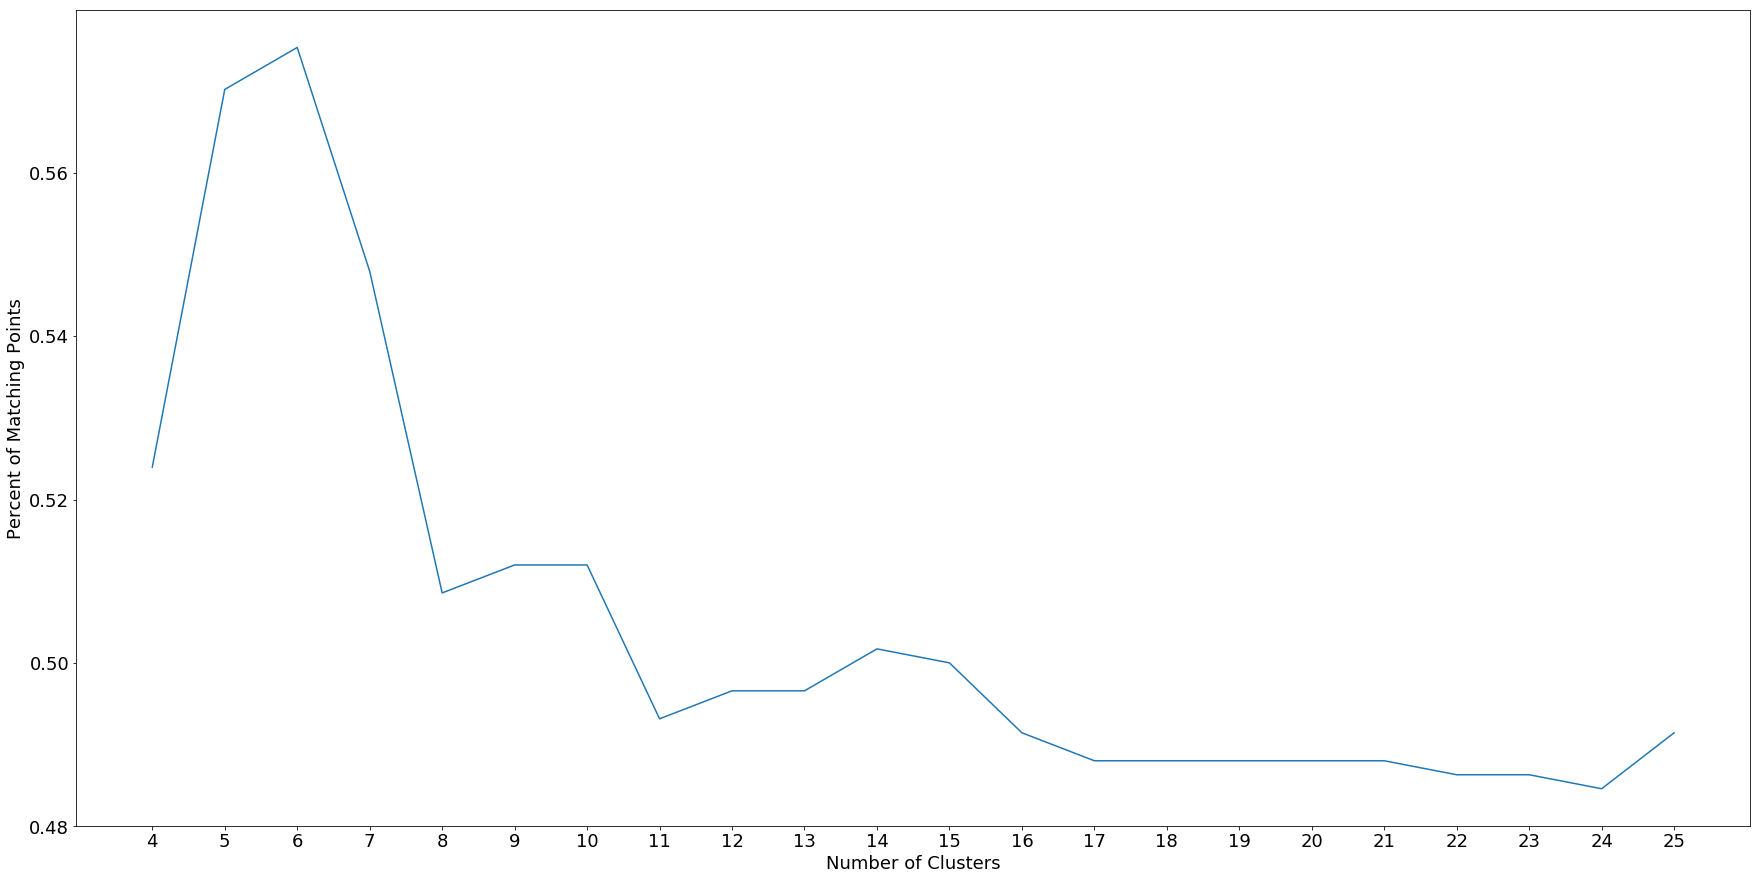

In [179]:
fig, ax = plt.subplots(figsize=(30,15))
plt.plot(np.arange(4,26), result_list_op)
plt.xticks(np.arange(4, 26, step=1), fontsize=18)
plt.yticks( fontsize=18)
plt.xlabel("Number of Clusters",fontsize=18)
plt.ylabel("Percent of Matching Points",fontsize=18)
plt.savefig("Assignment_Problem_non_standard.png");

In [180]:
n_components = 6
level = 12
temporal_limits = {"time_min":datetime(1948, 1, 1, 0, 0),"time_max":datetime(2016, 1, 1, 0, 0) } 
spatial_limits = {"lon_min":-40,"lon_max":60,"lat_min":-40,"lat_max":40}

In [181]:
d = Data('GPCC_half.nc','precip',temporal_limits, missing_value=-9.96921e+36)

result = d.get_data()
lon_list = d.get_lon_list()
lat_list = d.get_lat_list()
lon = d.get_lon()
lat = d.get_lat()

In [182]:
d = Data('air_monthly_mean_africa.nc','air', missing_value=-9.96921e+36)

result_air = d.get_data()
lon_list_air = d.get_lon_list()
lat_list_air = d.get_lat_list()
lon_air = d.get_lon()
lat_air = d.get_lat()

In [164]:
#result = transform(result)

In [183]:
air_list = list(zip(lon_list_air,lat_list_air))

pre_list = list(zip(lon_list,lat_list))

clean_list = []
Idx = []
for i in range(len(air_list)):
    temp = neighbour_average(pre_list,pd.DataFrame(result),air_list[i][0], air_list[i][1])
    if temp.shape:
    #if not np.isnan(temp):
        clean_list.append(temp)
        Idx.append(i)
    #data[:,i,1] = np.squeeze(result_air[:,i])
    #data[:,i,0] = neighbour_average(pre_list,pd.DataFrame(result),air_list[i][0], air_list[i][1])

In [184]:
precipitation = np.array(clean_list)#/np.array(clean_list).std()
precipitation = pd.DataFrame(np.transpose(precipitation))

result_air = pd.DataFrame(result_air)
temperature = result_air.iloc[:,Idx]

#temperature = temperature/temperature.stack().std()

precipitation.columns = temperature.columns

combined_vertically = pd.concat([temperature,precipitation],ignore_index=True,sort=False, axis=0)

In [185]:
clustering = AgglomerativeClustering(n_clusters=n_components).fit(combined_vertically.transpose())
#clustering = KMeans(n_clusters=n_components).fit(combined_vertically.transpose())

In [168]:
clusters_air = np.zeros(len(lon_list_air))
clusters_air.fill(-1)

clusters_air[Idx] = clustering.labels_ 

index = np.argwhere(clusters_air == -1)

clusters_air = np.delete(clusters_air, index)
lat_list_air = np.delete(lat_list_air, index)
lon_list_air = np.delete(lon_list_air, index)

df_air = pd.DataFrame({"lons":lon_list_air,"lats":lat_list_air,"clusters":clusters_air})

lon_temp = df_air["lons"].values
lon_temp[lon_temp > 180] = lon_temp[lon_temp > 180] -360
df_air["lons"] = lon_temp

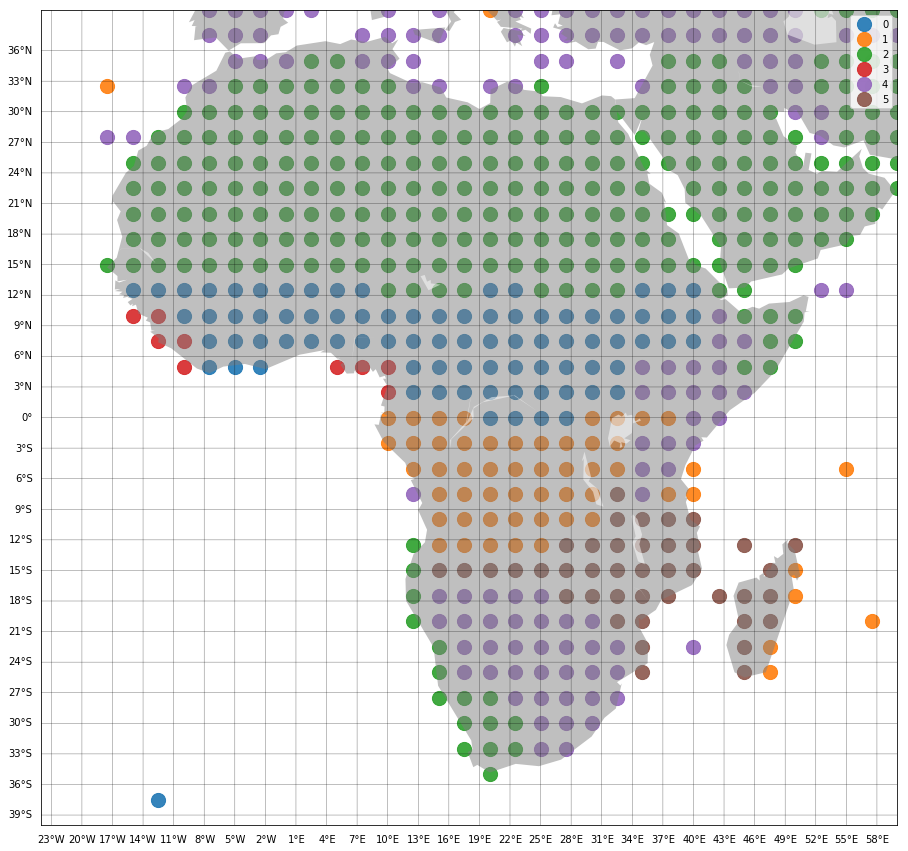

In [186]:
clusters_air = np.zeros(len(lon_list_air))
clusters_air.fill(-1)

clusters_air[Idx] = clustering.labels_ 

index = np.argwhere(clusters_air == -1)

clusters_air = np.delete(clusters_air, index)
lat_list_air = np.delete(lat_list_air, index)
lon_list_air = np.delete(lon_list_air, index)

df_air = pd.DataFrame({"lons":lon_list_air,"lats":lat_list_air,"clusters":clusters_air})

lon_temp = df_air["lons"].values
lon_temp[lon_temp > 180] = lon_temp[lon_temp > 180] -360
df_air["lons"] = lon_temp

df_list = []
for j in range(len(set(clusters_air))):
    df_list.append(pd.DataFrame(columns=df_air.columns))

#lon = np.arange(-23.75,60.0,2.5)

#fig, ax = plt.subplots(2,1,1)
fig, ax = plt.subplots(figsize=(30,15))
#fig = plt.figure(figsize=(30,15))
#ax = fig.add_subplot(111)
m = Basemap(llcrnrlon=-24, llcrnrlat=-40,urcrnrlon=60,urcrnrlat=40)
m.fillcontinents(color='grey', alpha=0.5)
m.drawparallels(np.arange(int(-39.75),int(39.75),3),labels=[1,0,0,0],linewidth=0.5)
m.drawmeridians(np.arange(int(-29.75),int(59.75),3),labels=[0,0,0,1],linewidth=0.5)
#m.drawcoastlines()
#colors = pf.random_color_1(n_components)

i = 0
for j in set(clusters_air):
    values = df_air["clusters"].values  
    Idx = np.where(values == j)[0]
    df_list[i] = df_air.iloc[Idx,:]
    df_list[i]["values"] = values[Idx]

    lons = df_list[i]["lons"].values
    lats = df_list[i]["lats"].values
    x,y = m(lons, lats)
    ax.scatter(x, y, alpha=0.9, s=200, label = i)
    i+=1

    
plt.legend()
plt.savefig("6_Clusters_non_standard.png")
plt.show()

In [169]:
class_air = []
for i in range(len(clusters_air)):
    r = neighbour_vote_class(df_air,lat_list_air[i],lon_list_air[i])  
    if r.size == 0:
        class_air.append('NAN')
    else:
        most_common,num_most_common = Counter(r).most_common(1)[0]
        class_air.append(most_common)

In [170]:
df_class = pd.DataFrame({"lons":lon_list_air,"lats":lat_list_air,"clusters":class_air})

lon_temp = df_class["lons"].values
lon_temp[lon_temp > 180] = lon_temp[lon_temp > 180] -360
df_class["lons"] = lon_temp

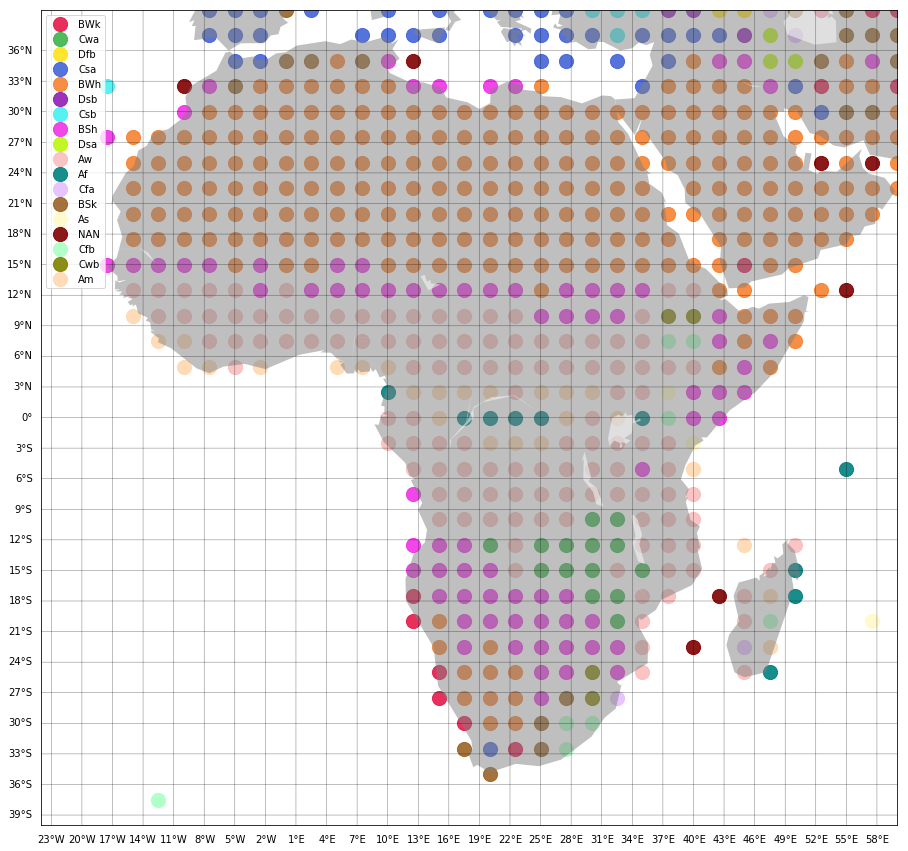

In [171]:
df_class = pd.DataFrame({"lons":lon_list_air,"lats":lat_list_air,"clusters":class_air})

lon_temp = df_class["lons"].values
lon_temp[lon_temp > 180] = lon_temp[lon_temp > 180] -360
df_class["lons"] = lon_temp

df_list = []
for j in range(len(set(class_air))):
    df_list.append(pd.DataFrame(columns=df_class.columns))

#lon = np.arange(-23.75,60.0,2.5)

fig, ax = plt.subplots(figsize=(30,15))
#fig = plt.figure(figsize=(30,15))
#ax = fig.add_subplot(111)
m = Basemap(llcrnrlon=-24, llcrnrlat=-40,urcrnrlon=60,urcrnrlat=40)
m.fillcontinents(color='grey', alpha=0.5)
m.drawparallels(np.arange(int(-39.75),int(39.75),3),labels=[1,0,0,0],linewidth=0.5)
m.drawmeridians(np.arange(int(-29.75),int(59.75),3),labels=[0,0,0,1],linewidth=0.5)
#m.drawcoastlines()
#colors = pf.random_color_1(n_components)

colors = ['#e6194b', '#3cb44b', '#ffe119', '#4363d8', '#f58231', 
'#911eb4', '#46f0f0', '#f032e6', '#bcf60c', '#fabebe', '#008080', '#e6beff', '#9a6324', '#fffac8', 
'#800000', '#aaffc3', '#808000', '#ffd8b1', '#000075', '#808080', '#ffffff', '#000000']
#colors = pf.random_color(n_components_sst)

i = 0
for j in set(class_air):
    values = df_class["clusters"].values  
    Idx = np.where(values == j)[0]
    df_list[i] = df_class.iloc[Idx,:]
    df_list[i]["values"] = values[Idx]

    lons = df_list[i]["lons"].values
    lats = df_list[i]["lats"].values
    x,y = m(lons, lats)
    ax.scatter(x, y, alpha=0.9, s=200, label = i, c = colors[i])
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles, set(class_air))
    i+=1

    
#plt.legend()
plt.savefig("Climate_Classes.png")
plt.show()

In [ ]:
from sklearn.metrics.cluster import adjusted_mutual_info_score,homogeneity_score, mutual_info_score, adjusted_rand_score, silhouette_score

In [83]:
mutual_info_score(clusters_air, class_air)

1.1796702666915873

In [84]:
adjusted_mutual_info_score(clusters_air, class_air)

0.41294852214133365

In [85]:
homogeneity_score(clusters_air, class_air)

0.45944490994925036

Automatically created module for IPython interactive environment
For n_clusters = 2 The average silhouette_score is : 0.28151566
For n_clusters = 3 The average silhouette_score is : 0.3228462
For n_clusters = 4 The average silhouette_score is : 0.33504984
For n_clusters = 5 The average silhouette_score is : 0.32254508
For n_clusters = 6 The average silhouette_score is : 0.26270875
For n_clusters = 7 The average silhouette_score is : 0.25430447
For n_clusters = 8 The average silhouette_score is : 0.25531235
For n_clusters = 9 The average silhouette_score is : 0.24884738
For n_clusters = 10 The average silhouette_score is : 0.24240327
For n_clusters = 11 The average silhouette_score is : 0.23730594
For n_clusters = 12 The average silhouette_score is : 0.23905632
For n_clusters = 13 The average silhouette_score is : 0.2432044


KeyboardInterrupt: 

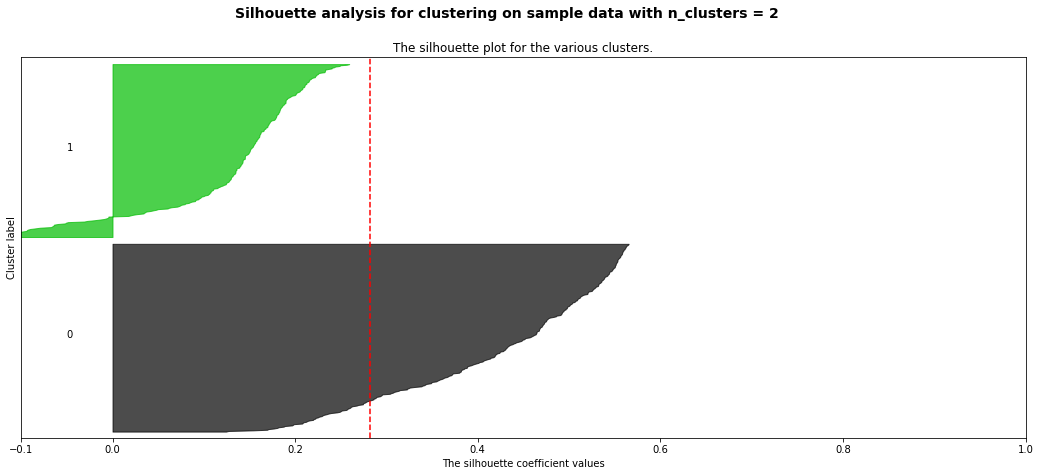

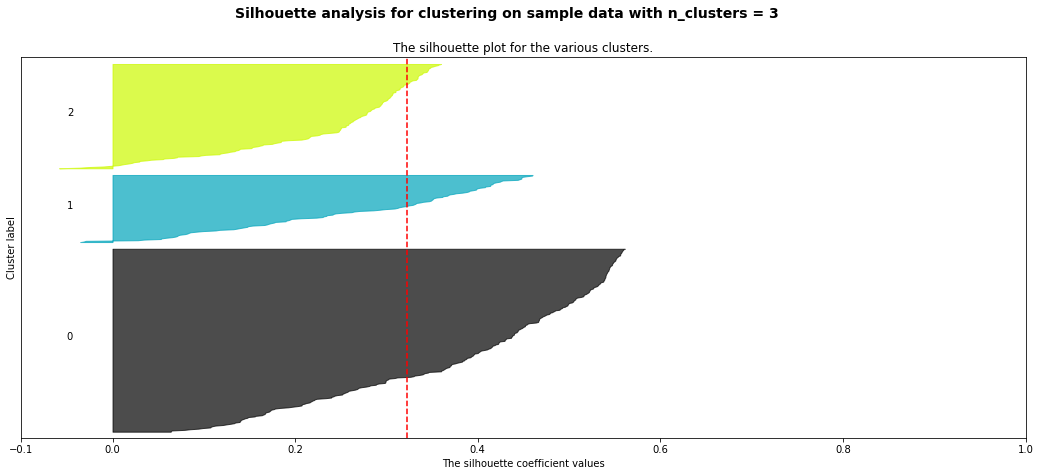

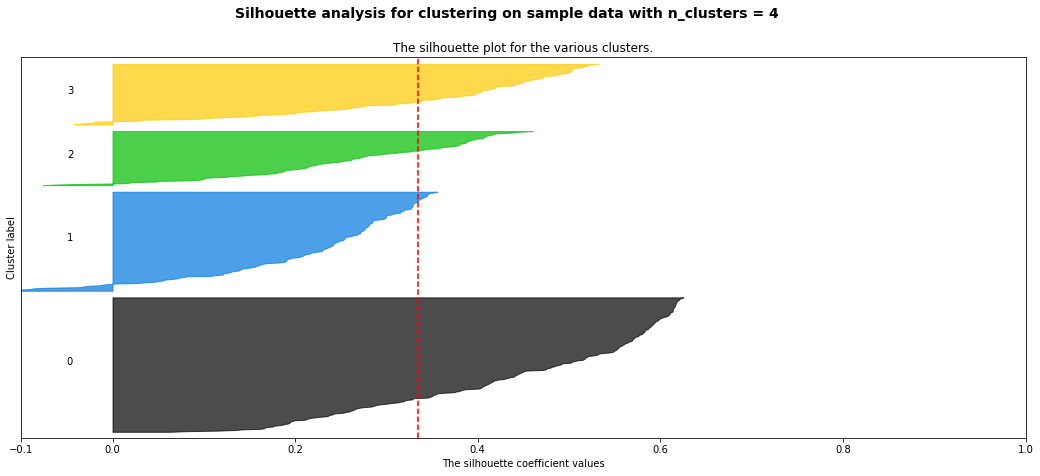

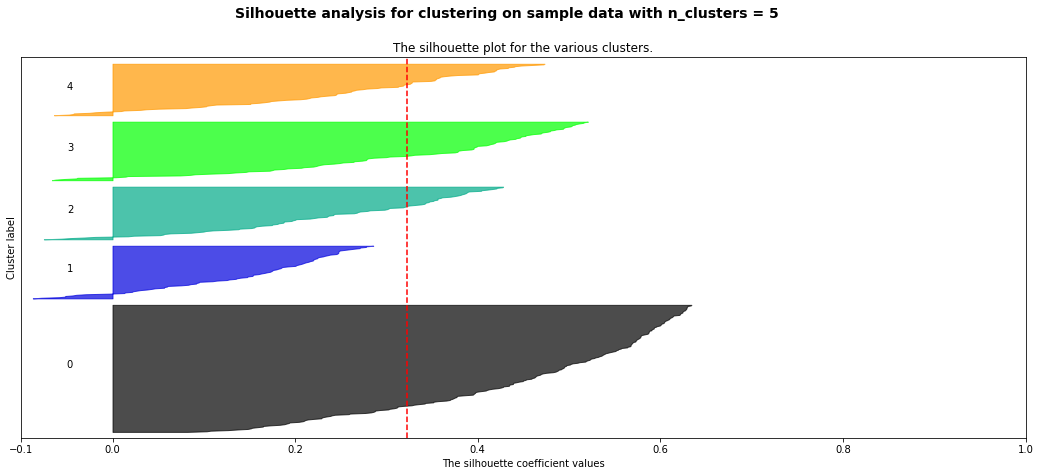

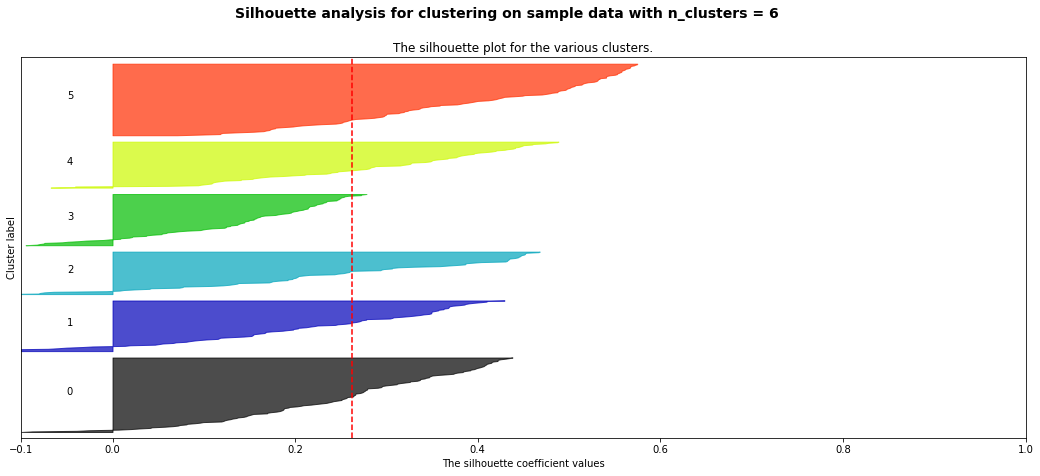

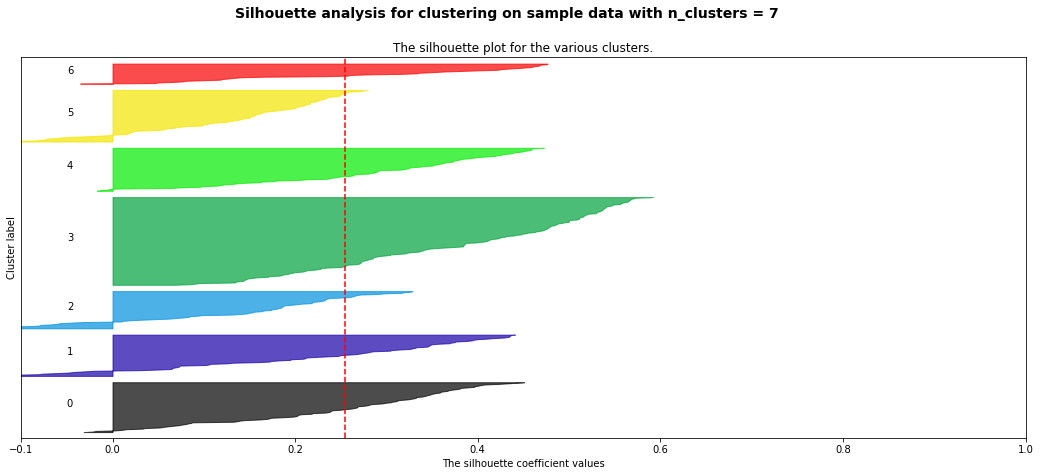

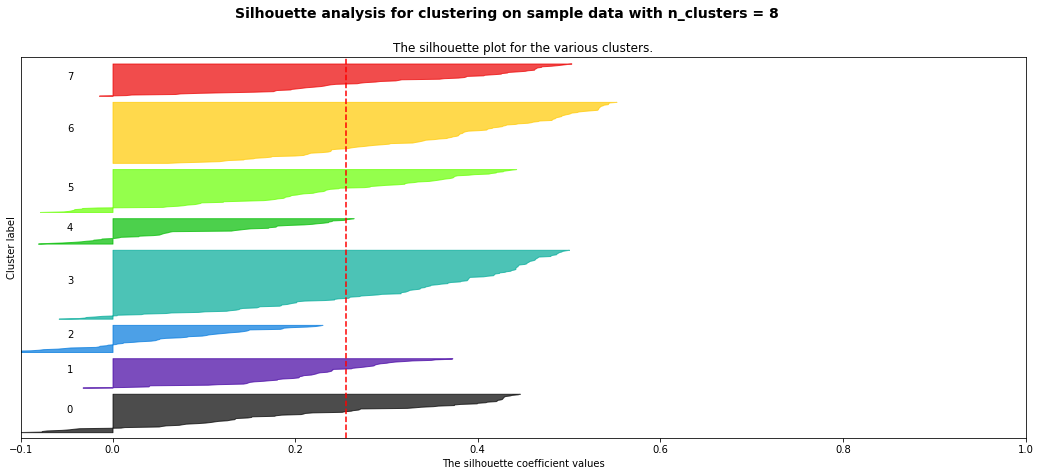

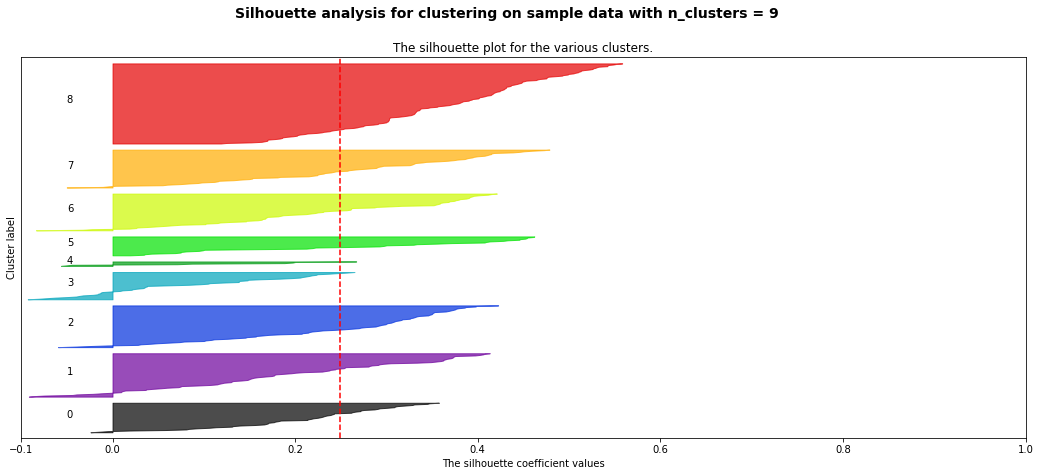

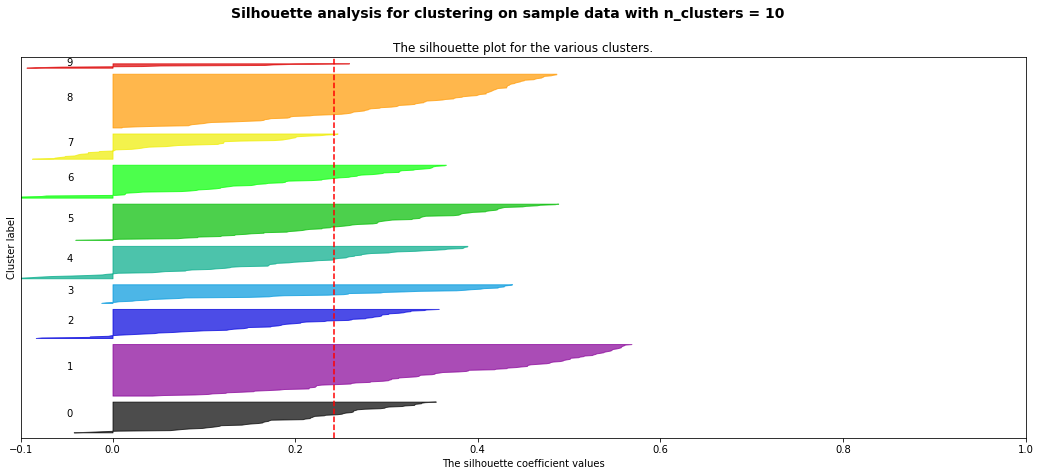

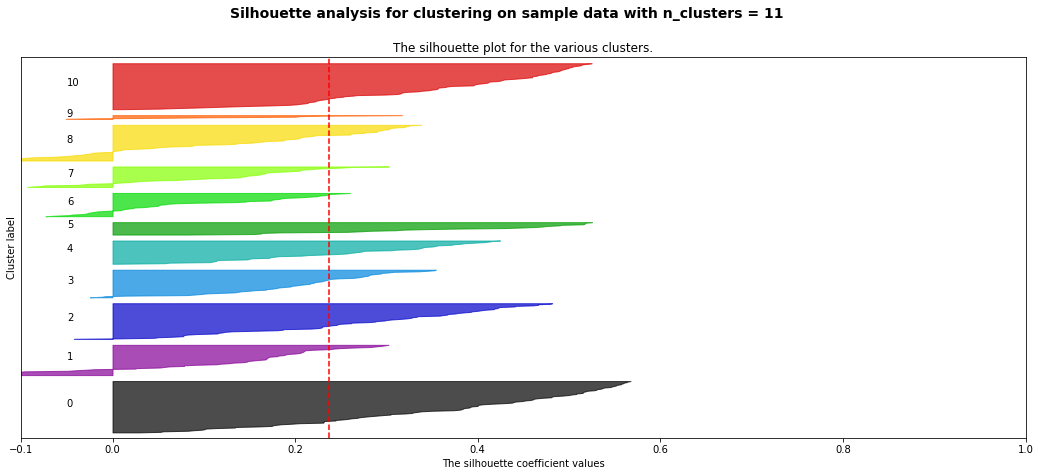

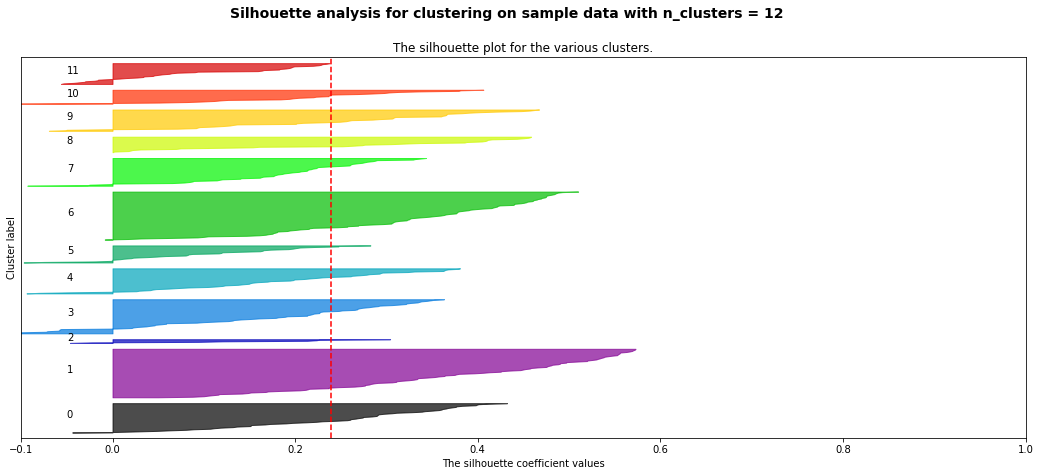

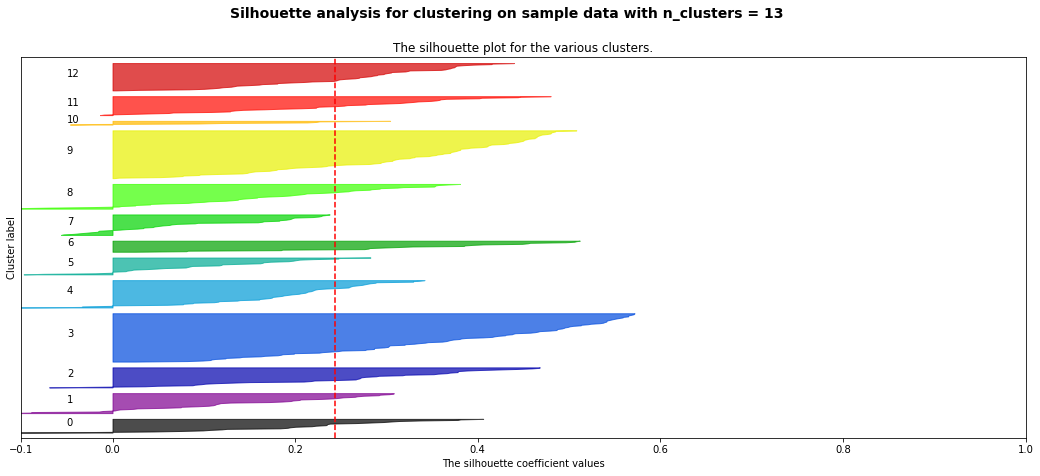

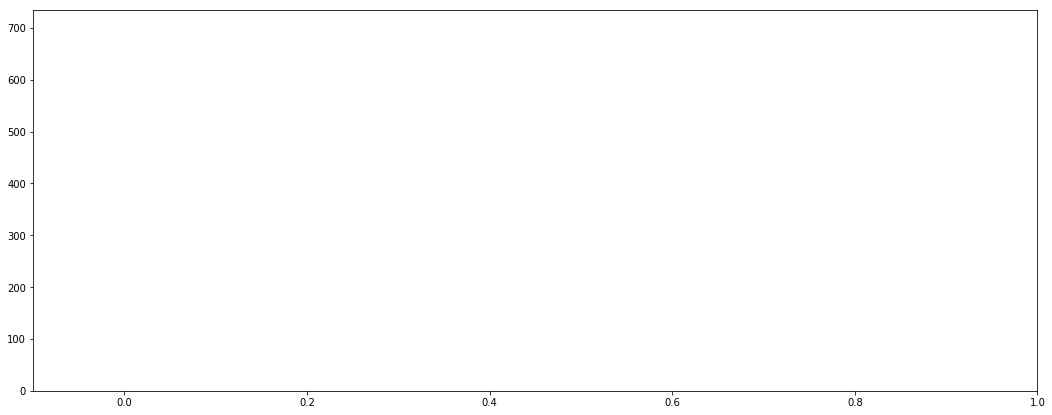

In [86]:
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

print(__doc__)

# Generating the sample data from make_blobs
# This particular setting has one distinct cluster and 3 clusters placed close
# together.
X, y = make_blobs(n_samples=500,
                  n_features=2,
                  centers=4,
                  cluster_std=1,
                  center_box=(-10.0, 10.0),
                  shuffle=True,
                  random_state=1)  # For reproducibility

X = combined_vertically.transpose()

range_n_clusters = np.arange(2,19)

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, ax1 = plt.subplots(1)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    #clusterer = AgglomerativeClustering(n_clusters=n_clusters)
    cluster_labels = clusterer.fit_predict(X)

    
    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    #ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,
    #            c=colors, edgecolor='k')

    # Labeling the clusters
   # centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    #ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
    #            c="white", alpha=1, s=200, edgecolor='k')

    #for i, c in enumerate(centers):
    #    ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
    #                s=50, edgecolor='k')

    #ax2.set_title("The visualization of the clustered data.")
    #ax2.set_xlabel("Feature space for the 1st feature")
    #ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show()

In [ ]:
similarity = np.zeros((len(set(clusters_air)),len(set(class_air))))

In [ ]:
values = df_air["clusters"].values
class_values = df_class["clusters"].values

In [ ]:
count_i = 0 
count_j = 0
for i in set(clusters_air): 
    index = np.where(values == i)[0]
    for j in set(class_air):         
        class_Idx = np.where(class_values == j)[0]
        similarity[count_i,count_j] = len(np.intersect1d(index,class_Idx))
        count_j += 1
    count_j = 0    
    count_i += 1

In [ ]:
n = 18

w = similarity

if w.shape[0]<n:
    d = n - w.shape[0]
    w = np.r_[w, np.zeros((d,n))]

In [ ]:
prob = p.LpProblem("ClusterAssigment", p.LpMaximize)

#Create a binary variable
#It determines which edge should be included
#And which one should be eliminated
assign_vars = p.LpVariable.dicts("X",
                                 [(i, j) for i in range(n)
                                  for j in range(n)],
                                 0, 1, p.LpBinary)

#Objective function
#Maximizing the sum of weights of included links
prob += p.lpSum(w[i,j] * assign_vars[i,j] for i in range(n) for j in range(n))

#Constrains: There must be either one or zero link originating from a node
for j in range(n):
    prob += p.lpSum(assign_vars[i,j] for i in range(n)) == 1

#Constrains: There must be either one or zero link going to a node
for i in range(n):
    prob += p.lpSum(assign_vars[i,j] for j in range(n)) == 1

#Running the optimization
prob.solve()


#Converting the result to a numpy array
result = np.zeros(w.shape)
matching_points = 0
for v in prob.variables():
    string  = str(v.name)
    r = re.findall(r"\w+",string)
    i = int(r[1])
    j = int(r[2][1:])
    if v.value() == 1: 
        matching_points += w[i,j]
    result[i,j] = v.value()



#Percentage of matching points 
n_points = np.sum(w)
result_list_op.append(matching_points/n_points)

In [ ]:
result_list_op

In [482]:
result_list_cp=[0.3424657534246575,
 0.5513698630136986,
 0.5513698630136986,
 0.541095890410959,
 0.3955479452054795,
 0.4006849315068493,
 0.3921232876712329,
 0.398972602739726,
 0.4023972602739726,
 0.3886986301369863,
 0.4041095890410959,
 0.4075342465753425,
 0.4126712328767123,
 0.4126712328767123,
 0.4126712328767123,
 0.4160958904109589,
 0.4023972602739726,
 0.3681506849315068,
 0.363013698630137,
 0.3476027397260274,
 0.3441780821917808,
 0.3424657534246575]

In [473]:
result_list_op.insert(0,matching_points/n_points)

In [481]:
result_list_op

[0.3424657534246575,
 0.5513698630136986,
 0.5513698630136986,
 0.541095890410959,
 0.3955479452054795,
 0.4006849315068493,
 0.3921232876712329,
 0.398972602739726,
 0.4023972602739726,
 0.3886986301369863,
 0.4041095890410959,
 0.4075342465753425,
 0.4126712328767123,
 0.4126712328767123,
 0.4126712328767123,
 0.4160958904109589,
 0.4023972602739726,
 0.3681506849315068,
 0.363013698630137,
 0.3476027397260274,
 0.3441780821917808,
 0.3424657534246575]

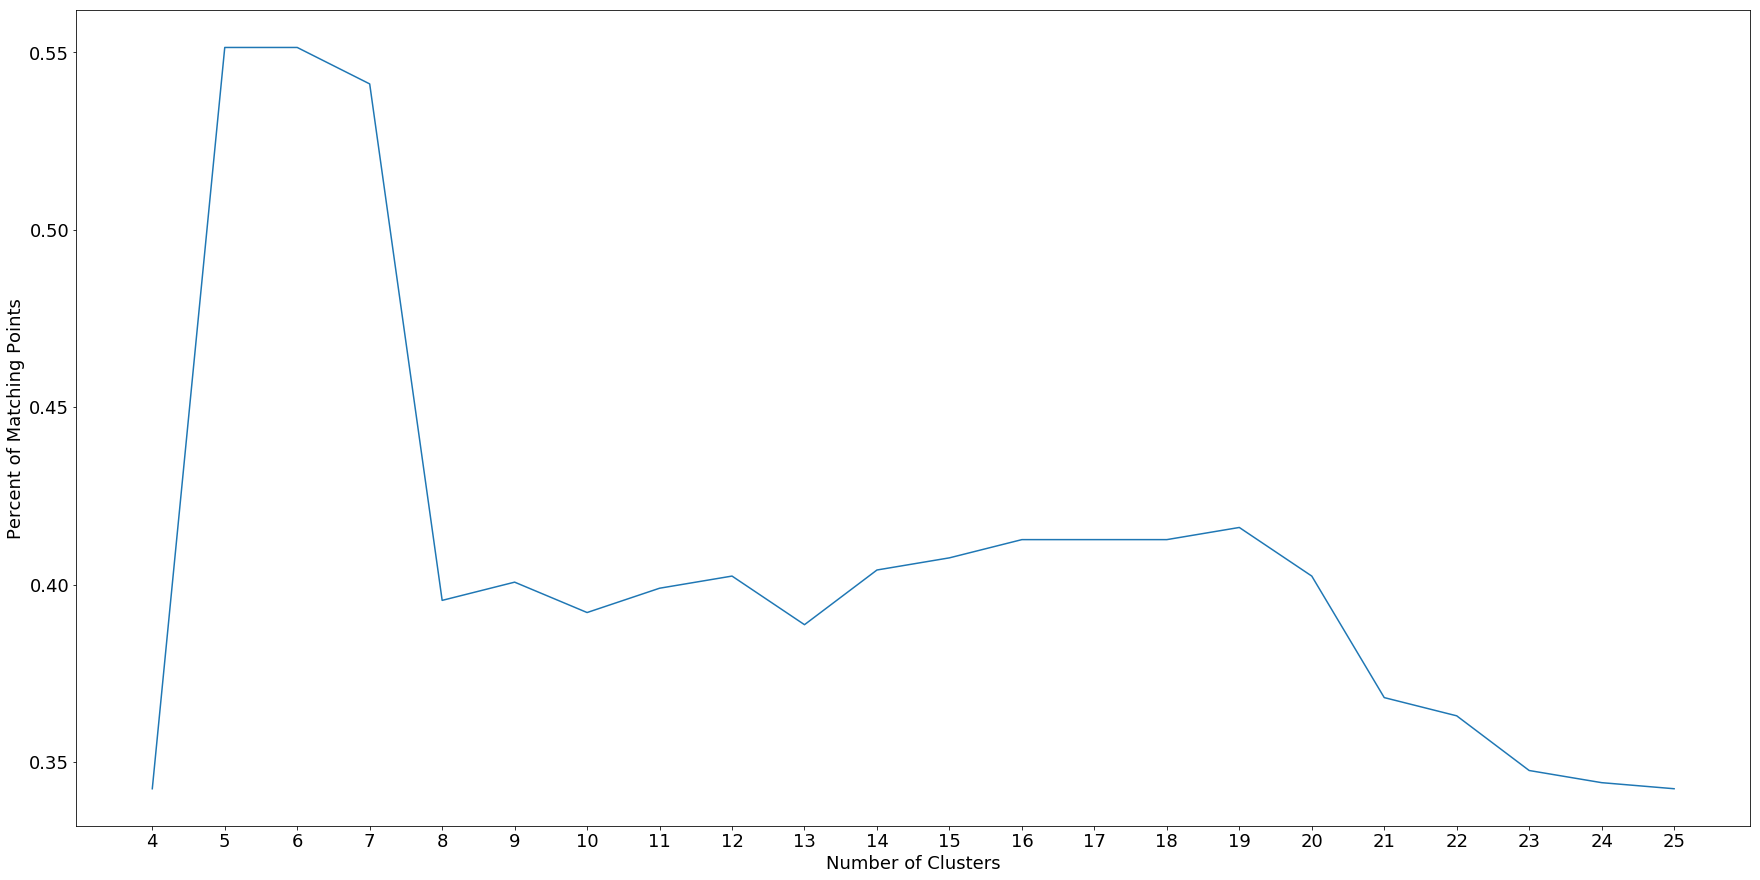

In [480]:
fig, ax = plt.subplots(figsize=(30,15))
plt.plot(np.arange(4,26), result_list_op)
plt.xticks(np.arange(4, 26, step=1), fontsize=18)
plt.yticks( fontsize=18)
plt.xlabel("Number of Clusters",fontsize=18)
plt.ylabel("Percent of Matching Points",fontsize=18)
plt.savefig("Assignment_Problem.png");

In [201]:
count_i = 0 
count_j = 0
for i in set(clusters_air): 
    Idx = np.where(values == i)[0]
    for j in set(class_air):         
        class_Idx = np.where(class_values == j)[0]
        similarity[count_i,count_j] = len(np.intersect1d(Idx,class_Idx))/(len(Idx) + len(class_Idx) - len(np.intersect1d(Idx,class_Idx)))
        count_j += 1
    count_j = 0    
    count_i += 1

In [18]:
similarity

array([[35.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  4.,  2.,
         1.,  0.,  1.,  0.,  0.],
       [ 0.,  2.,  1.,  0., 29.,  0.,  5.,  0.,  0.,  0.,  0.,  0., 11.,
         0.,  0.,  0., 12.,  0.],
       [42.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  5.,
         0.,  0.,  0.,  0.,  0.],
       [19.,  0.,  0.,  8.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  2.,  1.,
         0.,  0.,  0.,  0.,  0.],
       [ 0.,  3.,  0.,  0., 94.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  5.,
         0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  1.,  0.,
         0.,  0.,  4.,  0.,  0.],
       [ 6.,  2.,  0.,  6.,  5.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 24.,
         0.,  0.,  0.,  0.,  2.],
       [ 0.,  0.,  0.,  0., 86.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  3.,  0.,  2.,  0.,  0.,  0.,
         2.,  3.,  0.,  0.,  1.],
       [ 3.,  0.,  0.,  0.,  0.,  0.,

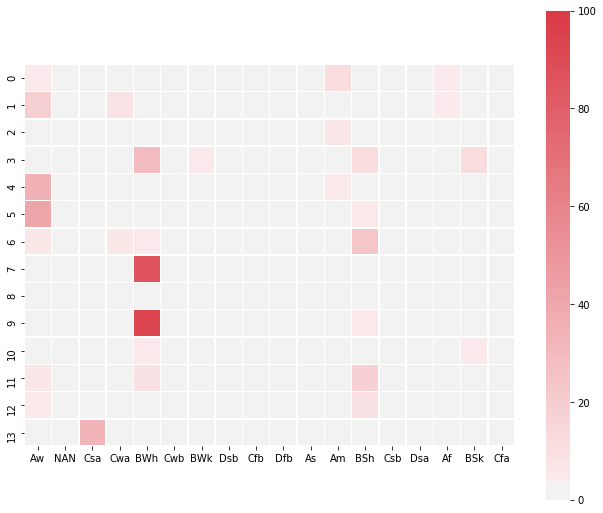

In [67]:
x_axis_labels = list(set(class_air)) # labels for x-axis

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(240,10,as_cmap=True)
#cmap = sns.diverging_palette(150, 275, s=80, l=55, n=9,as_cmap=True)
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(similarity,cmap=cmap, vmax=100, center=0,
            square=True, linewidths=.5, xticklabels=x_axis_labels)

In [68]:
np.save("similarity14.npy",similarity)

In [69]:
np.save("x_axis_labels14.npy",x_axis_labels)

In [91]:
import pulp as p
import re

In [75]:
#w = 3*np.random.randn(3,3) + 7

In [92]:
w = similarity

In [93]:
prob = p.LpProblem("ClusterAssigment", p.LpMaximize)

In [94]:
n = w.shape[0]

In [95]:
assign_vars = p.LpVariable.dicts("X",
                                 [(i, j) for i in range(n)
                                  for j in range(n)],
                                 0, 1, p.LpBinary)

In [96]:
prob += p.lpSum(w[i,j] * assign_vars[i,j] for i in range(n) for j in range(n))

In [97]:
for j in range(n):
    prob += p.lpSum(assign_vars[i,j] for i in range(n)) <= 1

In [98]:
for i in range(n):
    prob += p.lpSum(assign_vars[i,j] for j in range(n)) <= 1

In [99]:
prob.solve()

1

In [66]:
for v in prob.variables():
    print(v.name,v.value())

X_(0,_0) 0.0
X_(0,_1) 0.0
X_(0,_10) 0.0
X_(0,_11) 1.0
X_(0,_12) 0.0
X_(0,_13) 0.0
X_(0,_14) 0.0
X_(0,_15) 0.0
X_(0,_16) 0.0
X_(0,_2) 0.0
X_(0,_3) 0.0
X_(0,_4) 0.0
X_(0,_5) 0.0
X_(0,_6) 0.0
X_(0,_7) 0.0
X_(0,_8) 0.0
X_(0,_9) 0.0
X_(1,_0) 1.0
X_(1,_1) 0.0
X_(1,_10) 0.0
X_(1,_11) 0.0
X_(1,_12) 0.0
X_(1,_13) 0.0
X_(1,_14) 0.0
X_(1,_15) 0.0
X_(1,_16) 0.0
X_(1,_2) 0.0
X_(1,_3) 0.0
X_(1,_4) 0.0
X_(1,_5) 0.0
X_(1,_6) 0.0
X_(1,_7) 0.0
X_(1,_8) 0.0
X_(1,_9) 0.0
X_(10,_0) 0.0
X_(10,_1) 0.0
X_(10,_10) 0.0
X_(10,_11) 0.0
X_(10,_12) 0.0
X_(10,_13) 1.0
X_(10,_14) 0.0
X_(10,_15) 0.0
X_(10,_16) 0.0
X_(10,_2) 0.0
X_(10,_3) 0.0
X_(10,_4) 0.0
X_(10,_5) 0.0
X_(10,_6) 0.0
X_(10,_7) 0.0
X_(10,_8) 0.0
X_(10,_9) 0.0
X_(11,_0) 0.0
X_(11,_1) 0.0
X_(11,_10) 0.0
X_(11,_11) 0.0
X_(11,_12) 0.0
X_(11,_13) 0.0
X_(11,_14) 0.0
X_(11,_15) 0.0
X_(11,_16) 0.0
X_(11,_2) 0.0
X_(11,_3) 0.0
X_(11,_4) 0.0
X_(11,_5) 0.0
X_(11,_6) 0.0
X_(11,_7) 0.0
X_(11,_8) 0.0
X_(11,_9) 0.0
X_(12,_0) 0.0
X_(12,_1) 0.0
X_(12,_10) 1.0
X_(12,_11) 

In [100]:
result = np.zeros((len(set(clusters_air)),len(set(class_air))))
aggregating_points = 0
for v in prob.variables():
    string  = str(v.name)
    r = re.findall(r"\w+",string)
    i = int(r[1])
    j = int(r[2][1:])
    if v.value() == 1: 
        aggregating_points += similarity[i,j]
    result[i,j] = v.value()

In [101]:
aggregating_points

241.0

In [116]:
np.save("x_axis_labels.npy",x_axis_labels)

In [107]:
n_points = np.sum(similarity)

In [108]:
aggregating_points/n_points

0.4126712328767123

In [42]:
df_class.groupby("clusters").count()

lons  lats
clusters            
Af          10    10
Am          26    26
As           3     3
Aw         118   118
BSh         78    78
BSk         19    19
BWh        232   232
BWk         12    12
Cfa          4     4
Cfb          8     8
Csa         35    35
Csb          6     6
Cwa         14    14
Cwb          4     4
Dfb          2     2
Dsa          3     3
Dsb          3     3
NAN          7     7

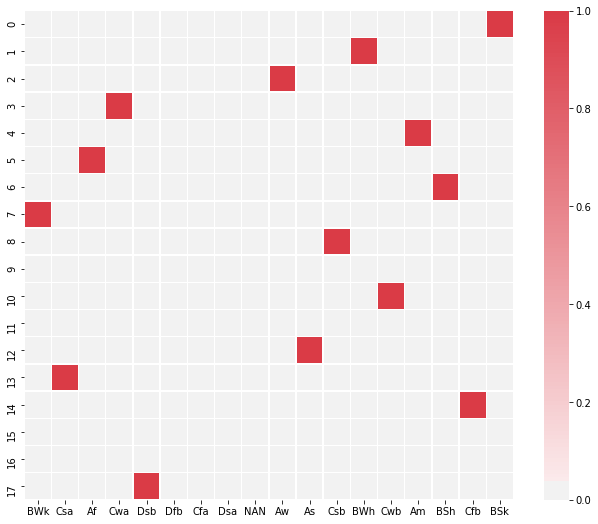

In [104]:
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(240,10,as_cmap=True)
#cmap = sns.diverging_palette(150, 275, s=80, l=55, n=9,as_cmap=True)
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(result,cmap=cmap, vmax=1, center=0,
            square=True, linewidths=.5, xticklabels=x_axis_labels)

# Deseasonalized Data using matrix norm:

In [108]:
d = Data('GPCC_half.nc','precip',temporal_limits, missing_value=-9.969209968386869e+36)

result = d.get_data()
lon_list = d.get_lon_list()
lat_list = d.get_lat_list()
lon = d.get_lon()
lat = d.get_lat()

d = Data('air_monthly_mean_africa.nc','air', missing_value=-9.96921e+36)

result_air = d.get_data()
lon_list_air = d.get_lon_list()
lat_list_air = d.get_lat_list()
lon_air = d.get_lon()
lat_air = d.get_lat()

In [87]:
result = pf.deseasonalize(np.array(result))
result_air = pf.deseasonalize(np.array(result_air))

In [9]:
air_list = list(zip(lon_list_air,lat_list_air))

pre_list = list(zip(lon_list,lat_list))

clean_list = []
index = []
for i in range(len(air_list)):
    temp = neighbour_average(pre_list,pd.DataFrame(result),air_list[i][0], air_list[i][1])
    if temp.shape:
    #if not np.isnan(temp):
        clean_list.append(temp)
        index.append(i)
    #data[:,i,1] = np.squeeze(result_air[:,i])
    #data[:,i,0] = neighbour_average(pre_list,pd.DataFrame(result),air_list[i][0], air_list[i][1])

In [10]:
data = np.zeros((result_air.shape[0],len(clean_list),2))

for i in range(len(clean_list)):

    data[:,i,1] = np.squeeze(result_air[:,index[i]])
    data[:,i,0] = clean_list[i]

distance = np.zeros((data.shape[1],data.shape[1]))

for i in range(data.shape[1]):
    for j in range(data.shape[1]):
        distance[i,j] = LA.norm(data[:,i,:]-data[:,j,:])


In [11]:
clustering = AgglomerativeClustering(n_clusters=n_components,affinity="precomputed",linkage="complete").fit(distance)

clusters_air = np.zeros(len(lon_list_air))
clusters_air.fill(-1)

clusters_air[index] = clustering.labels_ 

index = np.argwhere(clusters_air == -1)

clusters_air = np.delete(clusters_air, index)
lat_list_air = np.delete(lat_list_air, index)
lon_list_air = np.delete(lon_list_air, index)

df_air = pd.DataFrame({"lons":lon_list_air,"lats":lat_list_air,"clusters":clusters_air})

lon_temp = df_air["lons"].values
lon_temp[lon_temp > 180] = lon_temp[lon_temp > 180] -360
df_air["lons"] = lon_temp

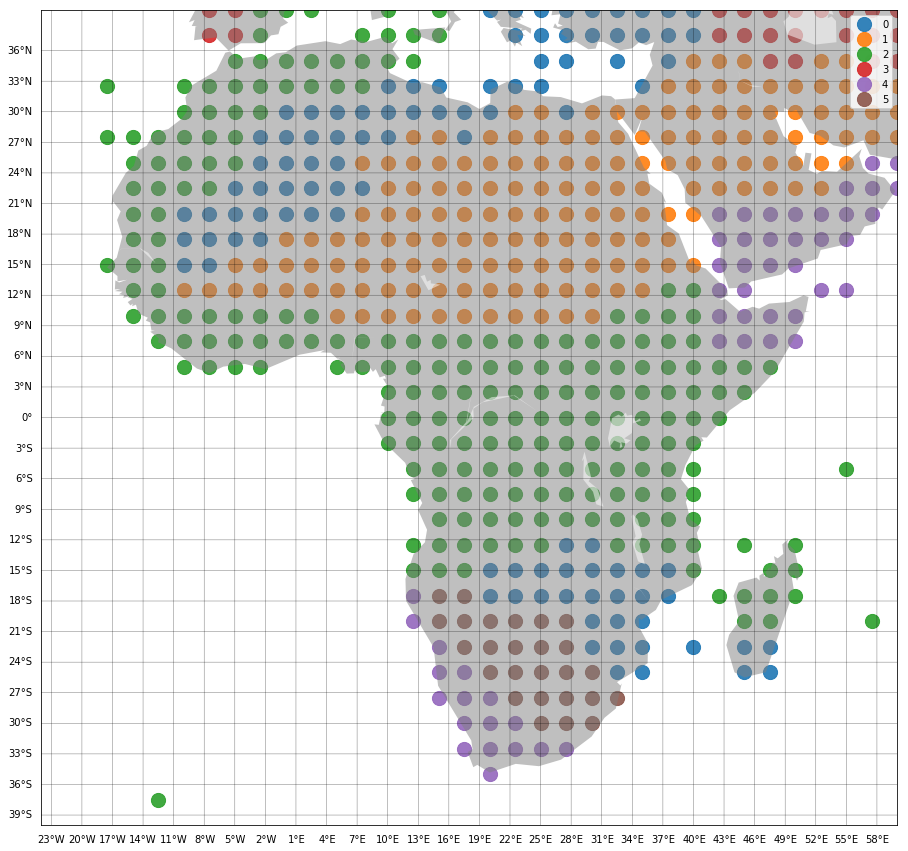

In [12]:
df_list = []
for j in range(len(set(clusters_air))):
    df_list.append(pd.DataFrame(columns=df_air.columns))

#lon = np.arange(-23.75,60.0,2.5)

fig, ax = plt.subplots(figsize=(30,15))
#fig = plt.figure(figsize=(30,15))
#ax = fig.add_subplot(111)
m = Basemap(llcrnrlon=-24, llcrnrlat=-40,urcrnrlon=60,urcrnrlat=40)
m.fillcontinents(color='grey', alpha=0.5)
m.drawparallels(np.arange(int(-39.75),int(39.75),3),labels=[1,0,0,0],linewidth=0.5)
m.drawmeridians(np.arange(int(-29.75),int(59.75),3),labels=[0,0,0,1],linewidth=0.5)
#m.drawcoastlines()
#colors = pf.random_color_1(n_components)

i = 0
for j in set(clusters_air):
    values = df_air["clusters"].values  
    Idx = np.where(values == j)[0]
    df_list[i] = df_air.iloc[Idx,:]
    df_list[i]["values"] = values[Idx]

    lons = df_list[i]["lons"].values
    lats = df_list[i]["lats"].values
    x,y = m(lons, lats)
    ax.scatter(x, y, alpha=0.9, s=200, label = i)
    i+=1

    
plt.legend()
plt.show()

# Deseasonalized Data using vector euclidean distance:

In [108]:
n_components = 15
level = 12
temporal_limits = {"time_min":datetime(1948, 1, 1, 0, 0),"time_max":datetime(2016, 1, 1, 0, 0) } 
spatial_limits = {"lon_min":-40,"lon_max":60,"lat_min":-40,"lat_max":40}

In [109]:
d = Data('GPCC_half.nc','precip',temporal_limits, missing_value=-9.969209968386869e+36)

result = d.get_data()
lon_list = d.get_lon_list()
lat_list = d.get_lat_list()
lon = d.get_lon()
lat = d.get_lat()

In [110]:
d = Data('air_monthly_mean_africa.nc','air', missing_value=-9.96921e+36)

result_air = d.get_data()
lon_list_air = d.get_lon_list()
lat_list_air = d.get_lat_list()
lon_air = d.get_lon()
lat_air = d.get_lat()

In [113]:
# You can load it
result = pf.transform(result)
result = pf.deseasonalize(np.array(result))

NameError: name 'result' is not defined

In [111]:
result_air = pf.deseasonalize(np.array(result_air))

In [28]:
np.save("result_deseasonalized.npy",result)

In [150]:
result = np.load("result_deseasonalized.npy")

In [112]:
result = np.load("spi1_half_48_16.npy")

In [44]:
result = np.nan_to_num(result)

In [113]:
air_list = list(zip(lon_list_air,lat_list_air))

pre_list = list(zip(lon_list,lat_list))

clean_list = []
Idx = []
for i in range(len(air_list)):
    temp = neighbour_average(pre_list,pd.DataFrame(result),air_list[i][0], air_list[i][1])
    if temp.shape:
    #if not np.isnan(temp):
        clean_list.append(temp)
        Idx.append(i)
    #data[:,i,1] = np.squeeze(result_air[:,i])
    #data[:,i,0] = neighbour_average(pre_list,pd.DataFrame(result),air_list[i][0], air_list[i][1])

In [114]:
precipitation = np.array(clean_list)#/np.array(clean_list).std()
precipitation = pd.DataFrame(np.transpose(precipitation))

result_air = pd.DataFrame(result_air)
temperature = result_air.iloc[:,Idx]

#temperature = temperature/temperature.stack().std()

precipitation.columns = temperature.columns

combined_vertically = pd.concat([temperature,precipitation],ignore_index=True,sort=False, axis=0)

In [115]:
clustering = AgglomerativeClustering(n_clusters=n_components).fit(combined_vertically.transpose())

In [116]:
clusters_air = np.zeros(len(lon_list_air))
clusters_air.fill(-1)

clusters_air[Idx] = clustering.labels_ 

index = np.argwhere(clusters_air == -1)

clusters_air = np.delete(clusters_air, index)
lat_list_air = np.delete(lat_list_air, index)
lon_list_air = np.delete(lon_list_air, index)

df_air = pd.DataFrame({"lons":lon_list_air,"lats":lat_list_air,"clusters":clusters_air})

lon_temp = df_air["lons"].values
lon_temp[lon_temp > 180] = lon_temp[lon_temp > 180] -360
df_air["lons"] = lon_temp

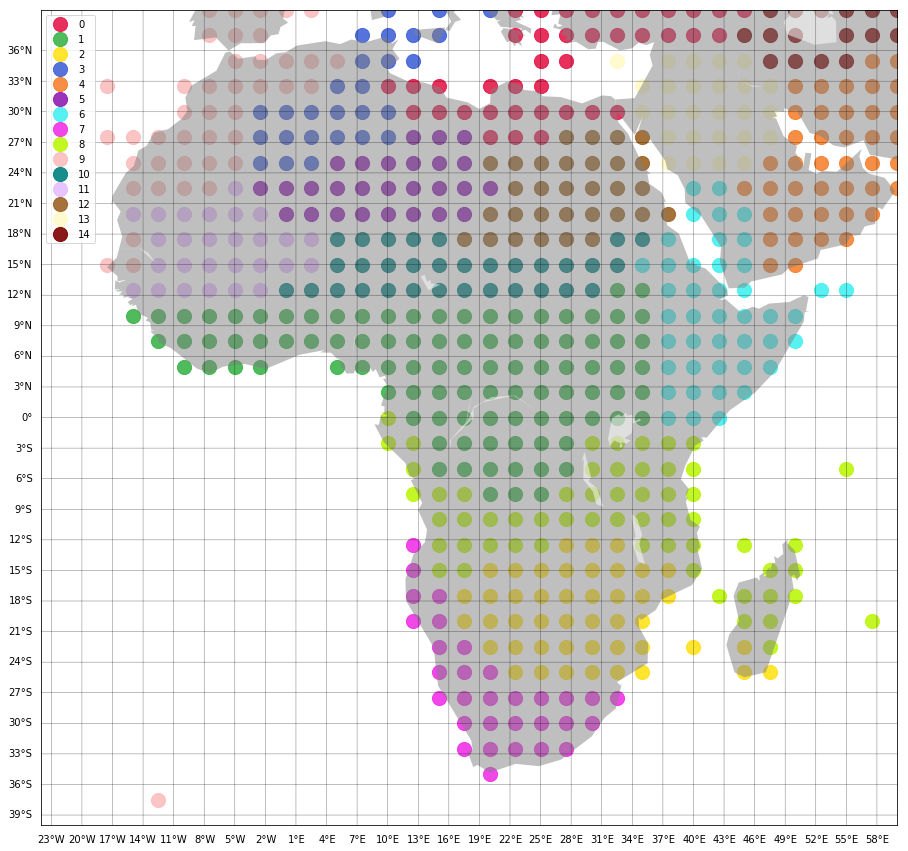

In [117]:
df_list = []
for j in range(len(set(clusters_air))):
    df_list.append(pd.DataFrame(columns=df_air.columns))

#lon = np.arange(-23.75,60.0,2.5)

fig, ax = plt.subplots(figsize=(30,15))
#fig = plt.figure(figsize=(30,15))
#ax = fig.add_subplot(111)
m = Basemap(llcrnrlon=-24, llcrnrlat=-40,urcrnrlon=60,urcrnrlat=40)
m.fillcontinents(color='grey', alpha=0.5)
m.drawparallels(np.arange(int(-39.75),int(39.75),3),labels=[1,0,0,0],linewidth=0.5)
m.drawmeridians(np.arange(int(-29.75),int(59.75),3),labels=[0,0,0,1],linewidth=0.5)
#m.drawcoastlines()
#colors = pf.random_color_1(n_components)
colors = ['#e6194b', '#3cb44b', '#ffe119', '#4363d8', '#f58231', 
'#911eb4', '#46f0f0', '#f032e6', '#bcf60c', '#fabebe', '#008080', '#e6beff', '#9a6324', '#fffac8', 
'#800000', '#aaffc3', '#808000', '#ffd8b1', '#000075', '#808080', '#ffffff', '#000000']

i = 0
for j in set(clusters_air):
    values = df_air["clusters"].values  
    Idx = np.where(values == j)[0]
    df_list[i] = df_air.iloc[Idx,:]
    df_list[i]["values"] = values[Idx]

    lons = df_list[i]["lons"].values
    lats = df_list[i]["lats"].values
    x,y = m(lons, lats)
    ax.scatter(x, y, alpha=0.9, s=200, label = i, c = colors[i] )
    i+=1

    
plt.legend()
plt.show()

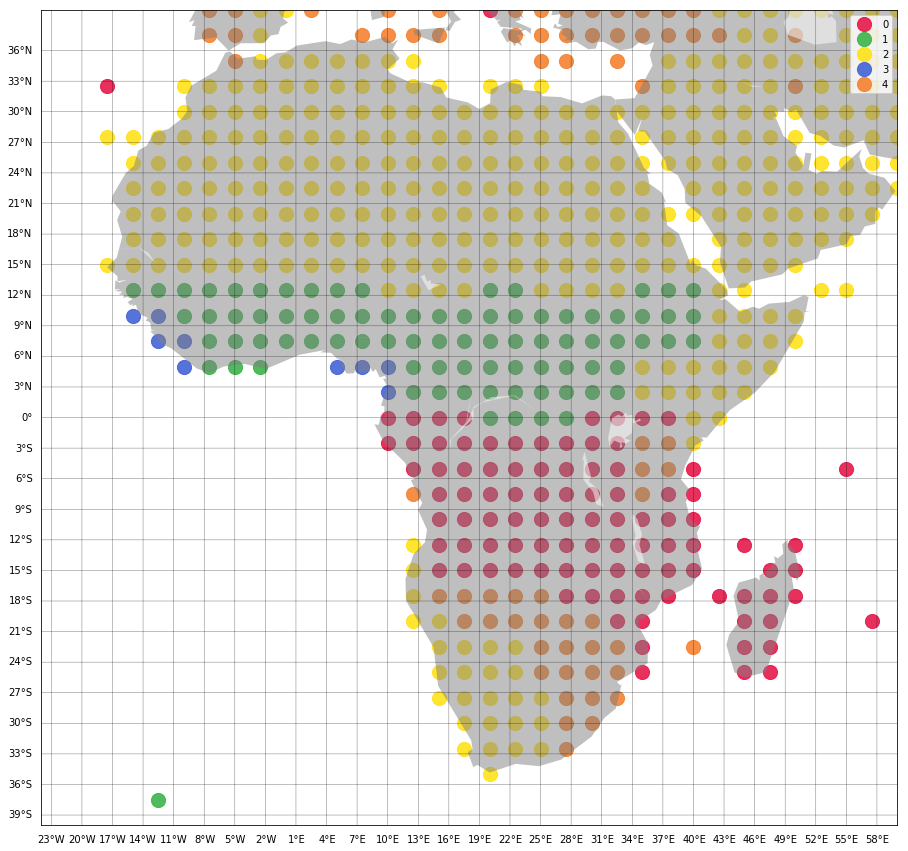

In [156]:
df_list = []
for j in range(len(set(clusters_air))):
    df_list.append(pd.DataFrame(columns=df_air.columns))

#lon = np.arange(-23.75,60.0,2.5)

fig, ax = plt.subplots(figsize=(30,15))
#fig = plt.figure(figsize=(30,15))
#ax = fig.add_subplot(111)
m = Basemap(llcrnrlon=-24, llcrnrlat=-40,urcrnrlon=60,urcrnrlat=40)
m.fillcontinents(color='grey', alpha=0.5)
m.drawparallels(np.arange(int(-39.75),int(39.75),3),labels=[1,0,0,0],linewidth=0.5)
m.drawmeridians(np.arange(int(-29.75),int(59.75),3),labels=[0,0,0,1],linewidth=0.5)
#m.drawcoastlines()
#colors = pf.random_color_1(n_components)
colors = ['#e6194b', '#3cb44b', '#ffe119', '#4363d8', '#f58231', 
'#911eb4', '#46f0f0', '#f032e6', '#bcf60c', '#fabebe', '#008080', '#e6beff', '#9a6324', '#fffac8', 
'#800000', '#aaffc3', '#808000', '#ffd8b1', '#000075', '#808080', '#ffffff', '#000000']

i = 0
for j in set(clusters_air):
    values = df_air["clusters"].values  
    Idx = np.where(values == j)[0]
    df_list[i] = df_air.iloc[Idx,:]
    df_list[i]["values"] = values[Idx]

    lons = df_list[i]["lons"].values
    lats = df_list[i]["lats"].values
    x,y = m(lons, lats)
    ax.scatter(x, y, alpha=0.9, s=200, label = i, c = colors[i] )
    i+=1

    
plt.legend()
plt.show()

In [144]:
metrics.calinski_harabaz_score(X, clusters_air)

20.274960563616848

In [142]:
X = combined_vertically.transpose()



AttributeError: module 'sklearn.metrics' has no attribute 'calinski_harabasz_score'

In [148]:
X = combined_vertically.transpose()
range_n_clusters = np.arange(2,19)
ch = []

for n_clusters in range_n_clusters:
    clustering = AgglomerativeClustering(n_clusters=n_clusters).fit(X)
    ch.append(metrics.calinski_harabaz_score(X, clustering.labels_))

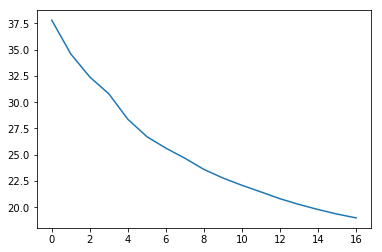

In [149]:
plt.plot(ch)

Automatically created module for IPython interactive environment
For n_clusters = 2 The average silhouette_score is : 0.05997496756917936
For n_clusters = 3 The average silhouette_score is : 0.07177192971431832
For n_clusters = 4 The average silhouette_score is : 0.08581181603717364
For n_clusters = 5 The average silhouette_score is : 0.08842933538845053
For n_clusters = 6 The average silhouette_score is : 0.08894474218209873
For n_clusters = 7 The average silhouette_score is : 0.08472678336379036
For n_clusters = 8 The average silhouette_score is : 0.08921122565904122
For n_clusters = 9 The average silhouette_score is : 0.08218109480730389
For n_clusters = 10 The average silhouette_score is : 0.08311380936198566
For n_clusters = 11 The average silhouette_score is : 0.08349842703700544
For n_clusters = 12 The average silhouette_score is : 0.08692287009433967
For n_clusters = 13 The average silhouette_score is : 0.08389705519502207
For n_clusters = 14 The average silhouette_score is : 0

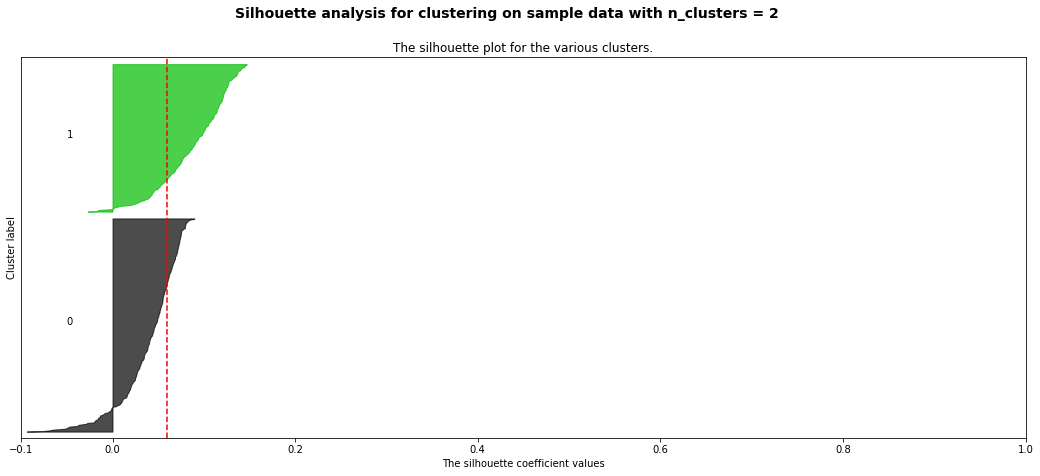

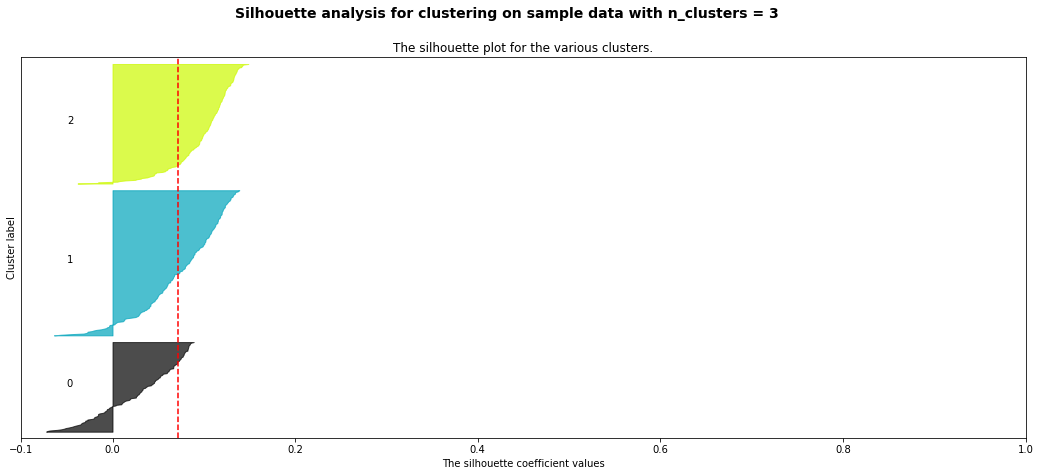

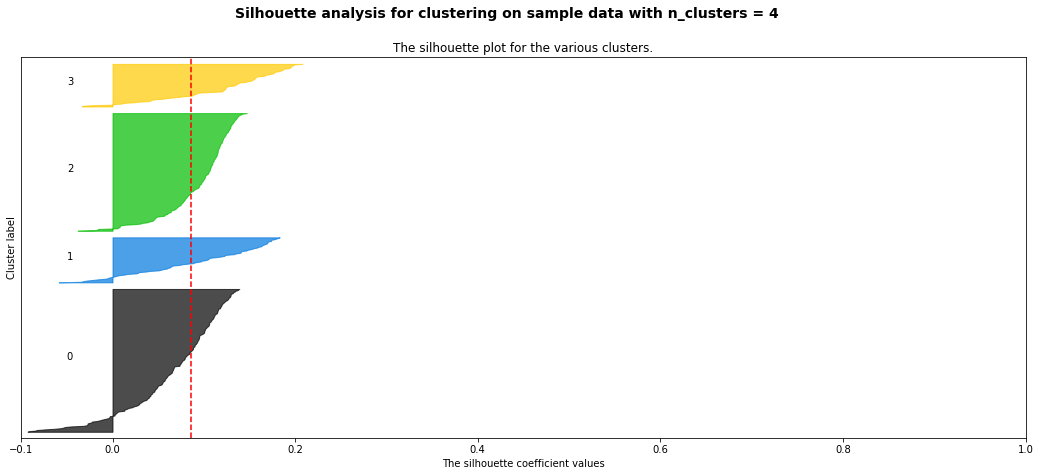

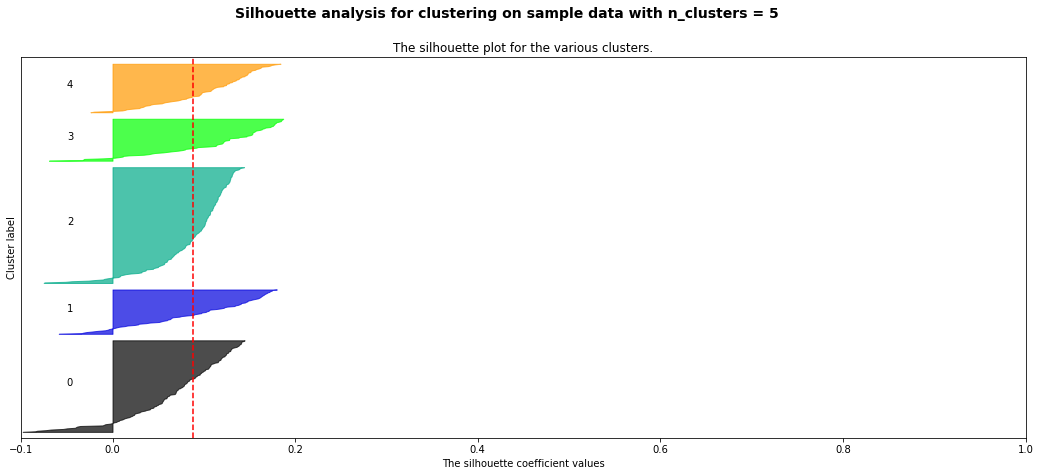

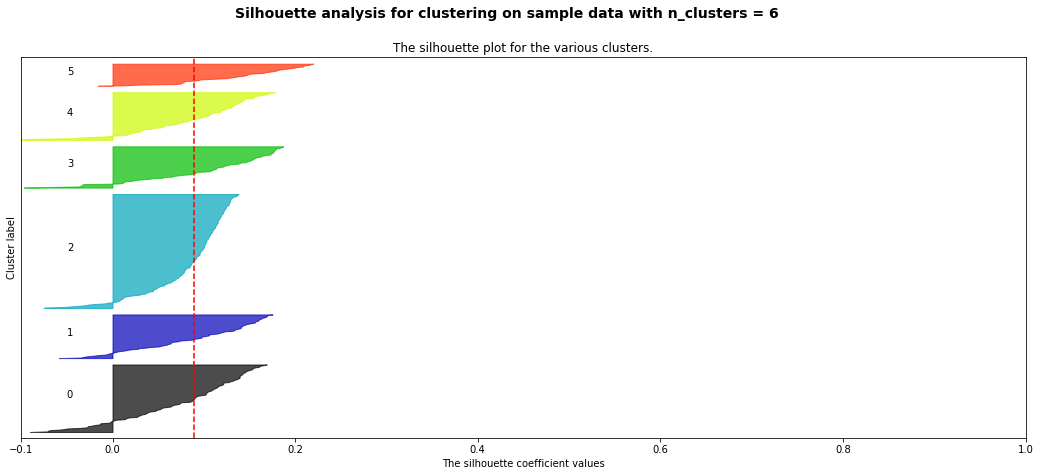

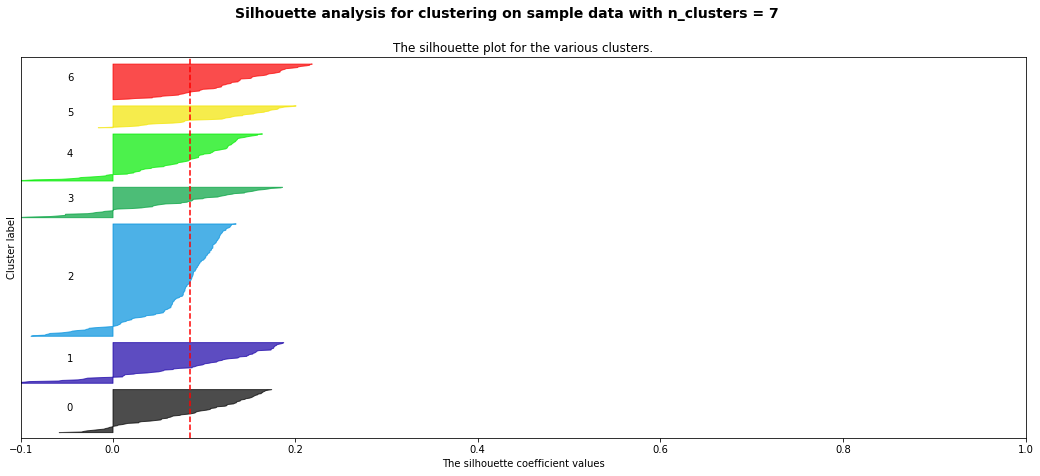

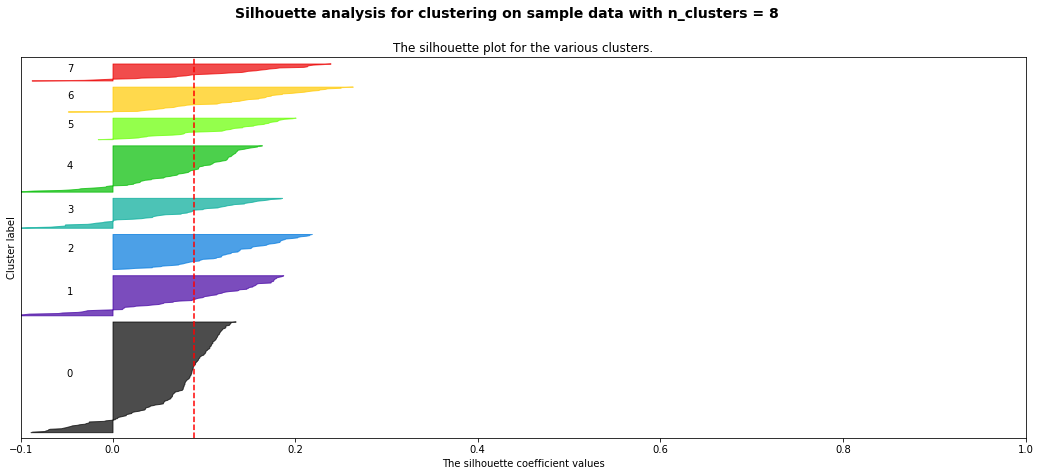

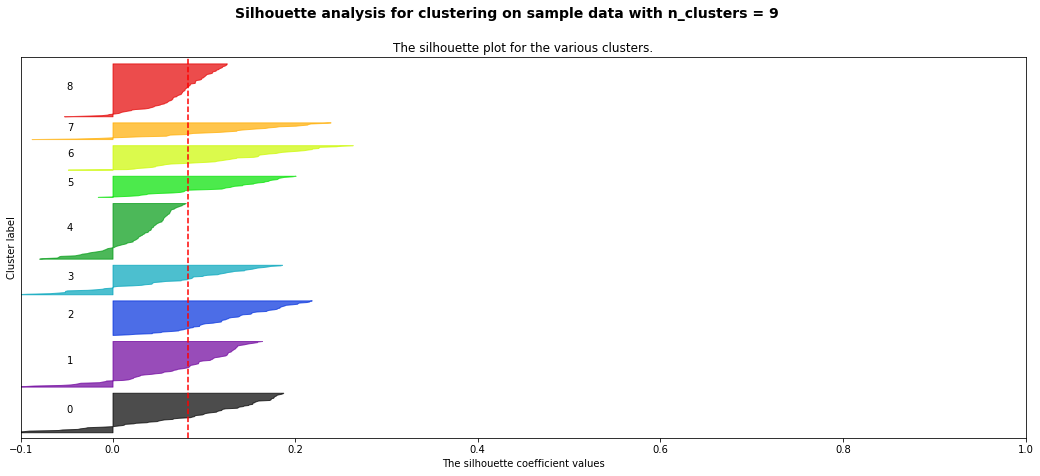

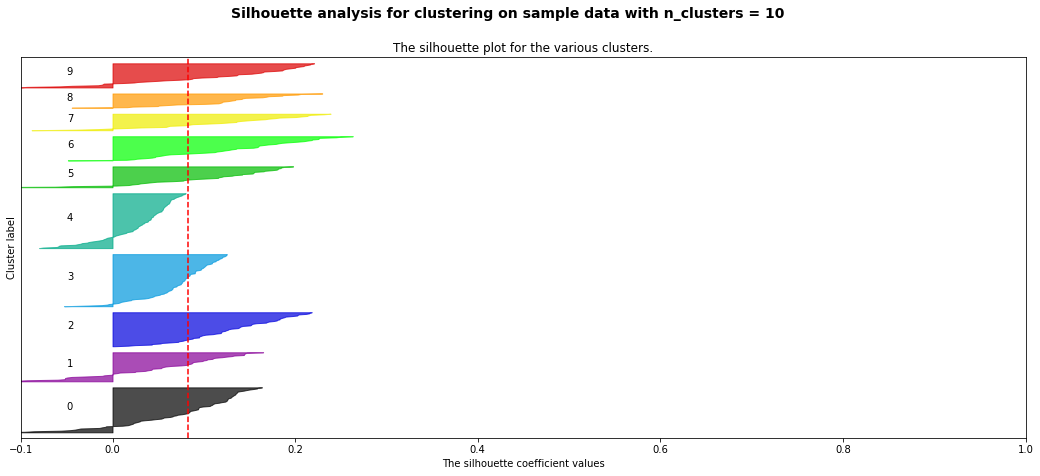

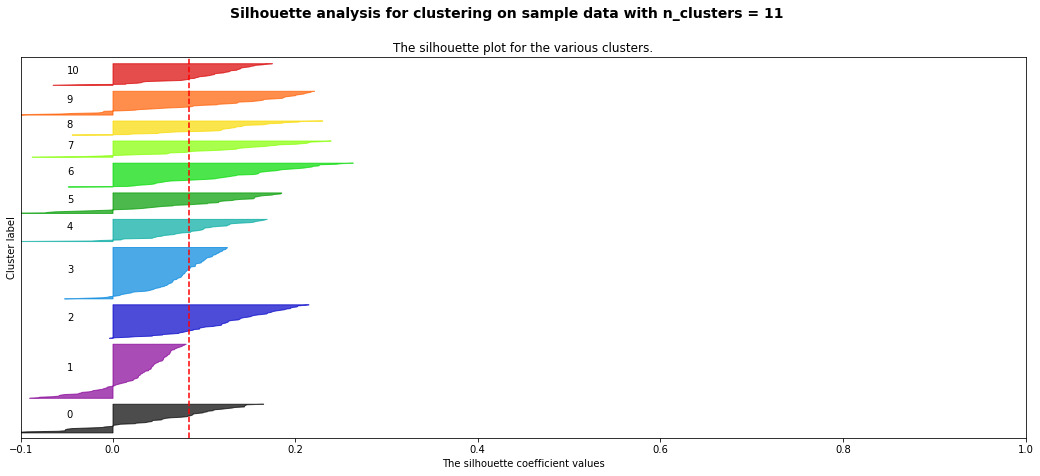

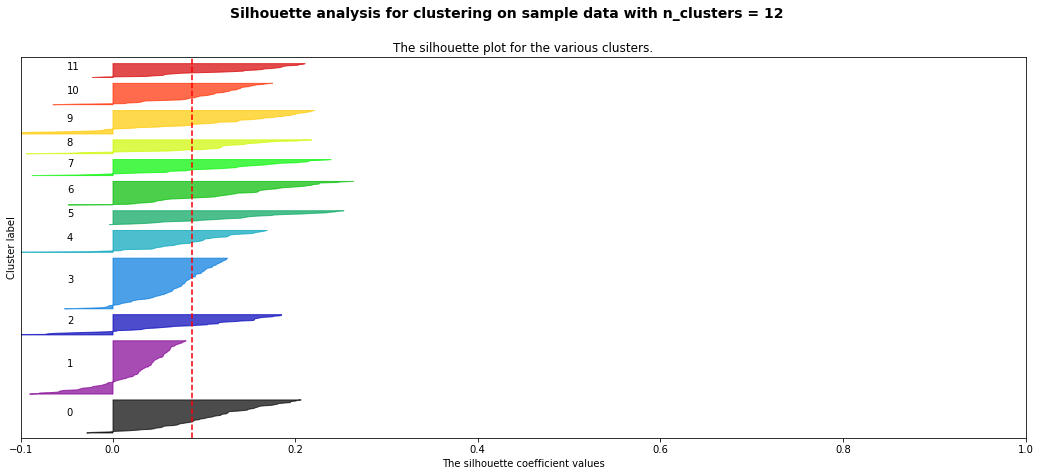

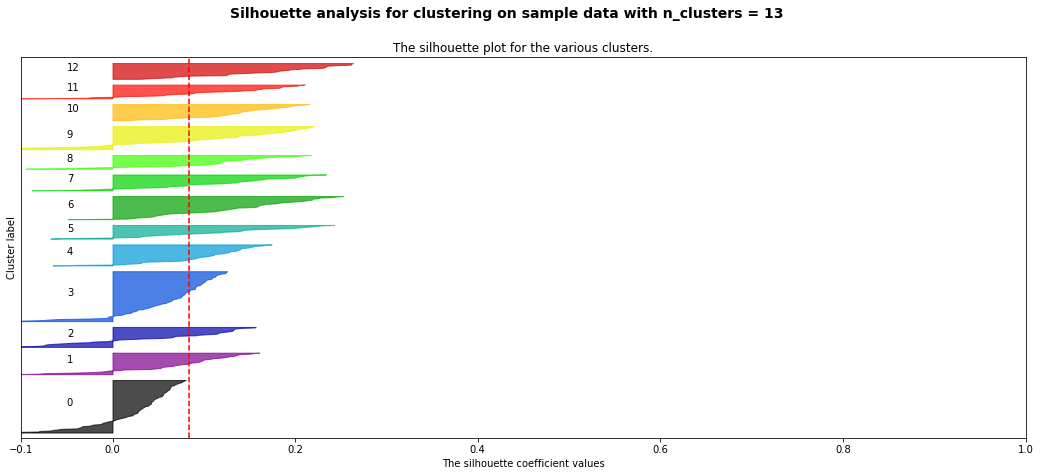

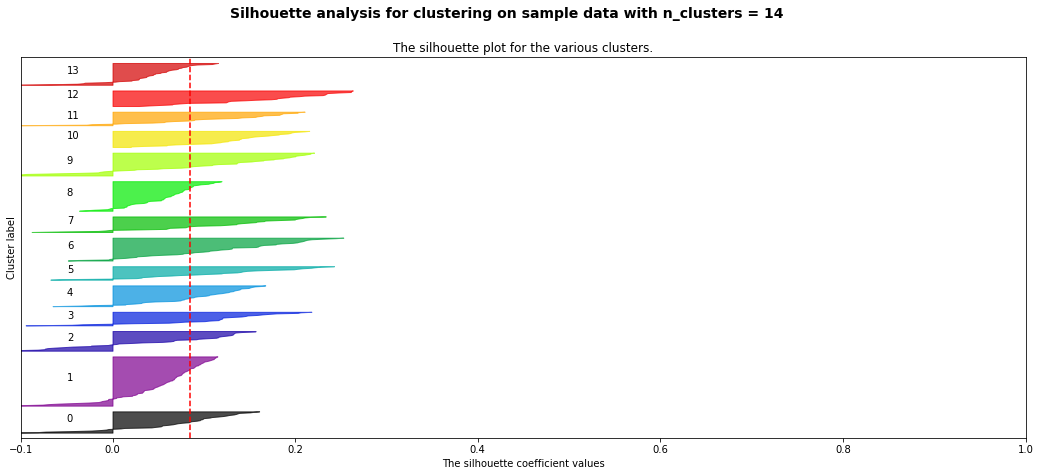

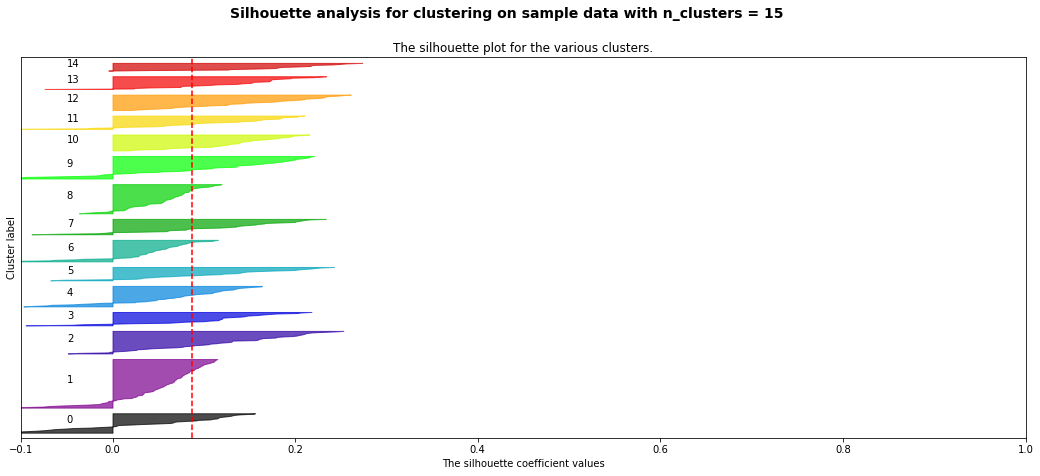

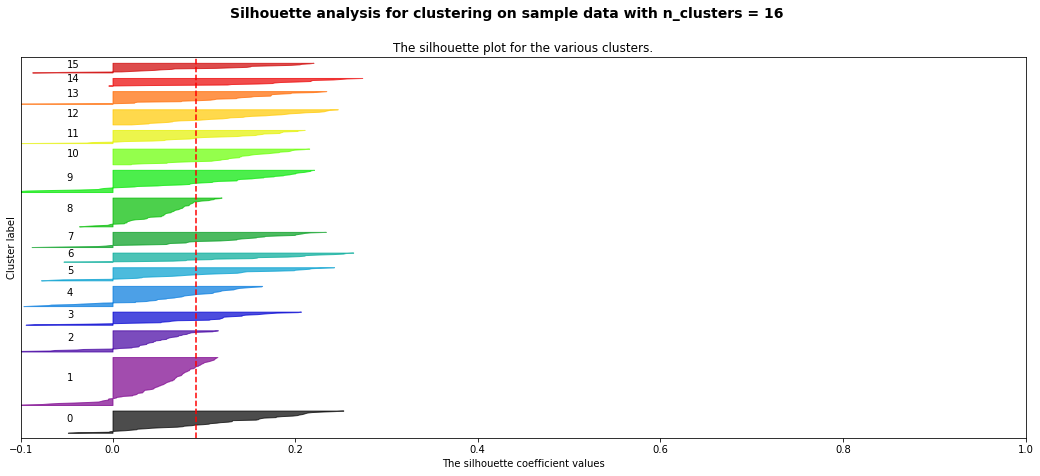

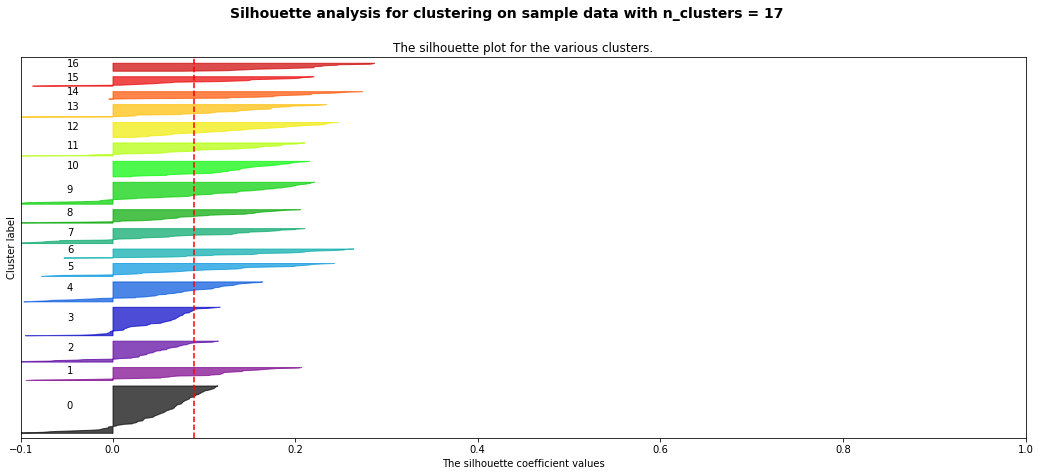

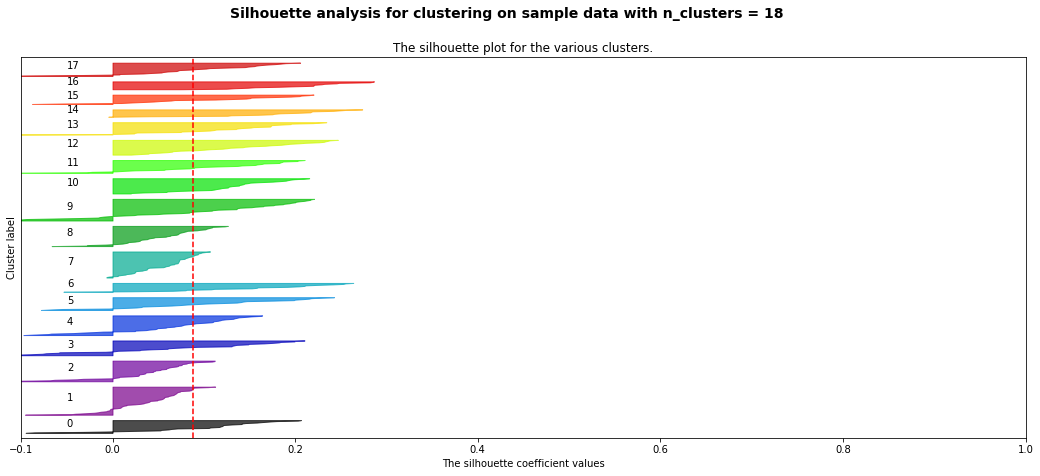

In [137]:
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

print(__doc__)

# Generating the sample data from make_blobs
# This particular setting has one distinct cluster and 3 clusters placed close
# together.
X, y = make_blobs(n_samples=500,
                  n_features=2,
                  centers=4,
                  cluster_std=1,
                  center_box=(-10.0, 10.0),
                  shuffle=True,
                  random_state=1)  # For reproducibility

X = combined_vertically.transpose()

range_n_clusters = np.arange(2,19)

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, ax1 = plt.subplots(1)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    #clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    clusterer = AgglomerativeClustering(n_clusters=n_clusters)
    cluster_labels = clusterer.fit_predict(X)

    
    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    #ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,
    #            c=colors, edgecolor='k')

    # Labeling the clusters
   # centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    #ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
    #            c="white", alpha=1, s=200, edgecolor='k')

    #for i, c in enumerate(centers):
    #    ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
    #                s=50, edgecolor='k')

    #ax2.set_title("The visualization of the clustered data.")
    #ax2.set_xlabel("Feature space for the 1st feature")
    #ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show()

In [122]:
cluster_data = []
for i in range(n_components):
    Idx = np.where((df_air.clusters == i).values)[0]
    temp = temperature.iloc[:,Idx]
    pre = precipitation.iloc[:,Idx]
    #r = pf.deseasonalize(np.array(r))
    combined_horizontally = pd.concat([temp,pre],ignore_index=True,sort=False, axis=1)
    scale = StandardScaler()
    scaled_data = scale.fit_transform(combined_horizontally)
    pca = PCA(n_components=n_components)
    pca_model = pca.fit(combined_horizontally)
    #print(pca_model.explained_variance_ratio_[0])
    pca_data = pca_model.transform(combined_horizontally)
    cluster_data.append(pca_data[:,0])

df_cluster = pd.DataFrame(np.transpose(np.matrix(cluster_data)))

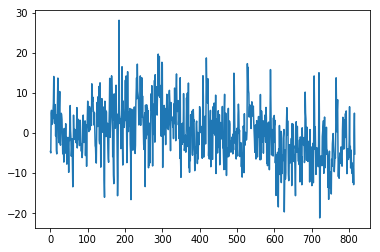

In [126]:
plt.plot(df_cluster.iloc[:,4])

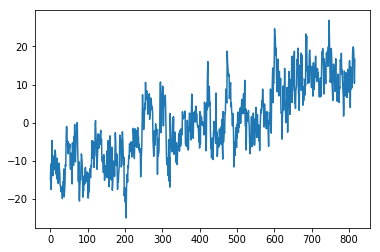

In [124]:
plt.plot(df_cluster.iloc[:,3])

In [123]:
adfuller(df_cluster.iloc[:,3])

(-22.744609362520546,
 0.0,
 0,
 816,
 {'1%': -3.4383892038884722,
  '10%': -2.568659512747501,
  '5%': -2.8650884667384955},
 4502.985409578847)

In [124]:
df_cluster

0          1         2         3         4         5          6  \
0    11.095269  -8.688882  9.258493  2.989490 -0.299553  1.131230  -8.318324   
1     1.935026  -7.402742  5.312279  2.709291 -2.589497  0.259576  -2.636499   
2    -8.868347 -12.315302  8.084396 -3.013809  0.684885 -6.539915  -6.319068   
3    -2.025046  -8.285004  4.691675  1.915516  2.786779  5.045677  -3.372384   
4     3.528405  -2.094042  3.061621  1.425424  1.136137  5.187007   0.452905   
..         ...        ...       ...       ...       ...       ...        ...   
812  11.013766  14.406520 -4.504210  4.035229 -1.063051  7.748294  10.698081   
813   6.875735  12.543598 -5.934260  5.370444 -9.242473  4.654571  12.971507   
814   4.883930   9.753888 -1.030312  1.165488 -1.094708 -4.218207   9.191927   
815   0.406320  -0.013032 -7.725345  3.793431  2.040850 -7.980926   8.290617   
816   1.923787   6.409303 -8.678795  8.367319 -5.836518 -0.109418  10.451084   

             7          8          9         10        11        12  \
0     1.839973  -9.416621  -0.622667   0.592595 -3.699940 -4.511527   
1     0.169518  -7.379666  -5.383481   1.009921  0.471046 -2.432014   
2     6.723040 -10.490398  -4.140387   4.212294 -2.175696  5.468570   
3    -1.729809 -10.201284   3.904356  -4.859817 -1.119582 -6.472062   
4     0.417487  -5.829139   4.358691  -4.590282  1.995100 -2.538425   
..         ...        ...        ...        ...       ...       ...   
812  -3.080065   9.905147  -0.721067  -4.848179  3.668825 -9.669742   
813  -9.203795   9.163278  -4.999727  -4.630402  6.449069 -4.068056   
814   0.996310   8.386061  -4.485951   1.733843 -1.169990  1.508085   
815 -10.375205  11.092730 -10.505501  12.697660 -3.132039  8.483377   
816  -6.255332  12.815902 -13.866457   7.213250  4.233348  6.617628   

            13        14  
0    -5.561192  4.178651  
1    -2.243890  4.697618  
2     5.821059 -0.306743  
3     3.172785 -4.820771  
4     3.502314  4.115672  
..         ...       ...  
812 -10.438135  1.678916  
813  -8.578472  0.102707  
814  -1.254908 -1.418055  
815   3.129503 -0.958410  
816   0.061051  2.870895  

[817 rows x 15 columns]

In [130]:
var_names = df_cluster.columns

#pca_data = pca_model.transform(data)
#pca_data = result.dot(loading)
pca_data = np.matrix(df_cluster)

dataframe = pp.DataFrame(pca_data,var_names=var_names)
cond_ind_test = ParCorr()
pcmci = PCMCI(dataframe=dataframe, cond_ind_test=cond_ind_test)

In [131]:
results = pcmci.run_pcmci(tau_max=2, pc_alpha=None)
pcmci.print_significant_links(p_matrix=results['p_matrix'],
                                     val_matrix=results['val_matrix'],
                                     alpha_level=0.05)


## Significant links at alpha = 0.05:

    Variable 0 has 11 link(s):
        (13 0): pval = 0.00000 | val = -0.631
        (12 0): pval = 0.00000 | val = -0.601
        (5 0): pval = 0.00000 | val = 0.495
        (3 0): pval = 0.00000 | val = 0.424
        (14 0): pval = 0.00000 | val = 0.340
        (0 -1): pval = 0.00000 | val = 0.272
        (10 0): pval = 0.00000 | val = -0.252
        (11 0): pval = 0.00000 | val = 0.176
        (9 -1): pval = 0.00003 | val = -0.148
        (4 0): pval = 0.00434 | val = -0.101
        (1 -1): pval = 0.01358 | val = -0.087

    Variable 1 has 14 link(s):
        (1 -1): pval = 0.00000 | val = 0.494
        (8 0): pval = 0.00000 | val = 0.329
        (11 0): pval = 0.00000 | val = 0.279
        (6 0): pval = 0.00000 | val = 0.218
        (10 0): pval = 0.00000 | val = -0.210
        (2 0): pval = 0.00008 | val = -0.139
        (4 0): pval = 0.00085 | val = -0.118
        (13 -1): pval = 0.00318 | val = 0.104
        (8 -2): pval = 0.01616 | val = 

(<Figure size 2160x1080 with 3 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f95f530cb38>)

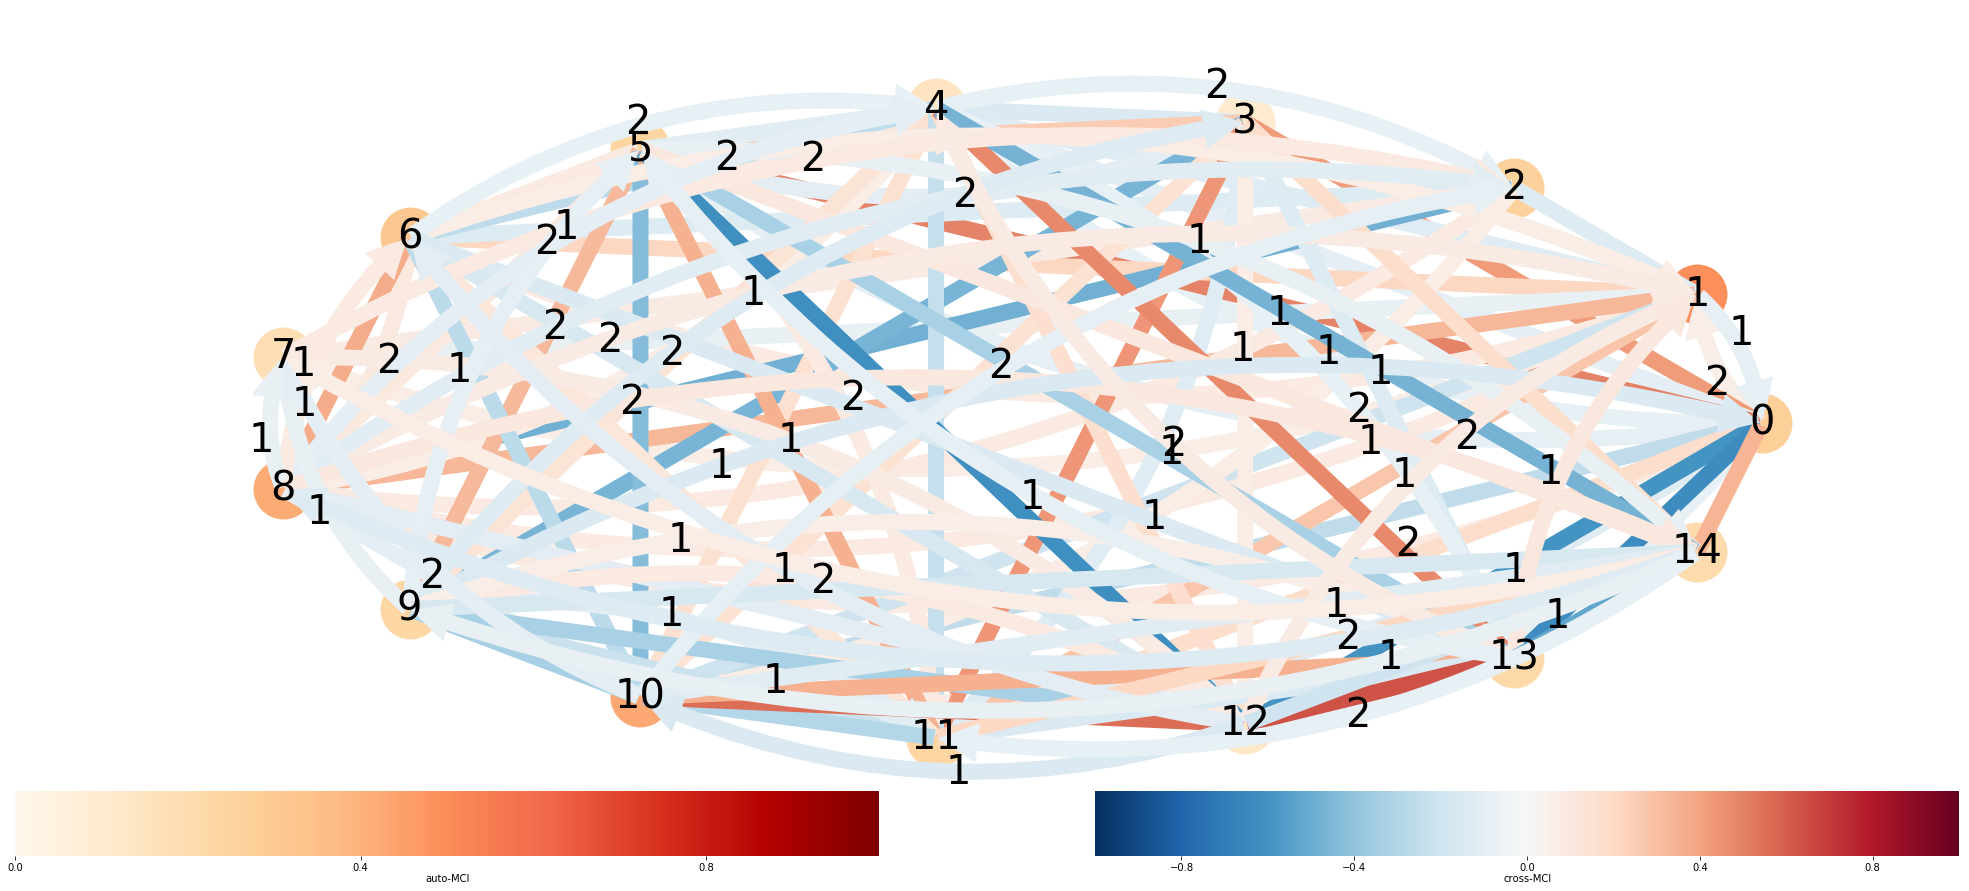

In [132]:
link_matrix = pcmci.return_significant_parents(pq_matrix=results['p_matrix'],
                        val_matrix=results['val_matrix'], alpha_level=0.05)['link_matrix']


tp.plot_graph(
    val_matrix=results['val_matrix'],
    link_matrix=link_matrix,
    link_colorbar_label='cross-MCI',
    node_colorbar_label='auto-MCI',figsize=(30,15),
    node_label_size=40,
    link_label_fontsize = 40,
    node_size = 60,
    arrow_linewidth = 80
    )

In [135]:
q_matrix = pcmci.get_corrected_pvalues(p_matrix=results['p_matrix'], fdr_method='fdr_bh')
pcmci.print_significant_links(
        p_matrix = results['p_matrix'], 
        q_matrix = q_matrix,
        val_matrix = results['val_matrix'],
        alpha_level = 0.01)

link_matrix = pcmci.return_significant_parents(pq_matrix=q_matrix,
                        val_matrix=results['val_matrix'], alpha_level=0.01)['link_matrix']




## Significant links at alpha = 0.01:

    Variable 0 has 10 link(s):
        (13 0): pval = 0.00000 | qval = 0.00000 | val = -0.631
        (12 0): pval = 0.00000 | qval = 0.00000 | val = -0.601
        (5 0): pval = 0.00000 | qval = 0.00000 | val = 0.495
        (3 0): pval = 0.00000 | qval = 0.00000 | val = 0.424
        (14 0): pval = 0.00000 | qval = 0.00000 | val = 0.340
        (0 -1): pval = 0.00000 | qval = 0.00000 | val = 0.272
        (10 0): pval = 0.00000 | qval = 0.00000 | val = -0.252
        (11 0): pval = 0.00000 | qval = 0.00000 | val = 0.176
        (9 -1): pval = 0.00003 | qval = 0.00084 | val = -0.148
        (4 0): pval = 0.00434 | qval = 0.00434 | val = -0.101

    Variable 1 has 7 link(s):
        (1 -1): pval = 0.00000 | qval = 0.00000 | val = 0.494
        (8 0): pval = 0.00000 | qval = 0.00000 | val = 0.329
        (11 0): pval = 0.00000 | qval = 0.00000 | val = 0.279
        (6 0): pval = 0.00000 | qval = 0.00000 | val = 0.218
        (10 0): pval = 0.00000

(<Figure size 2160x1080 with 3 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f95f4eb86a0>)

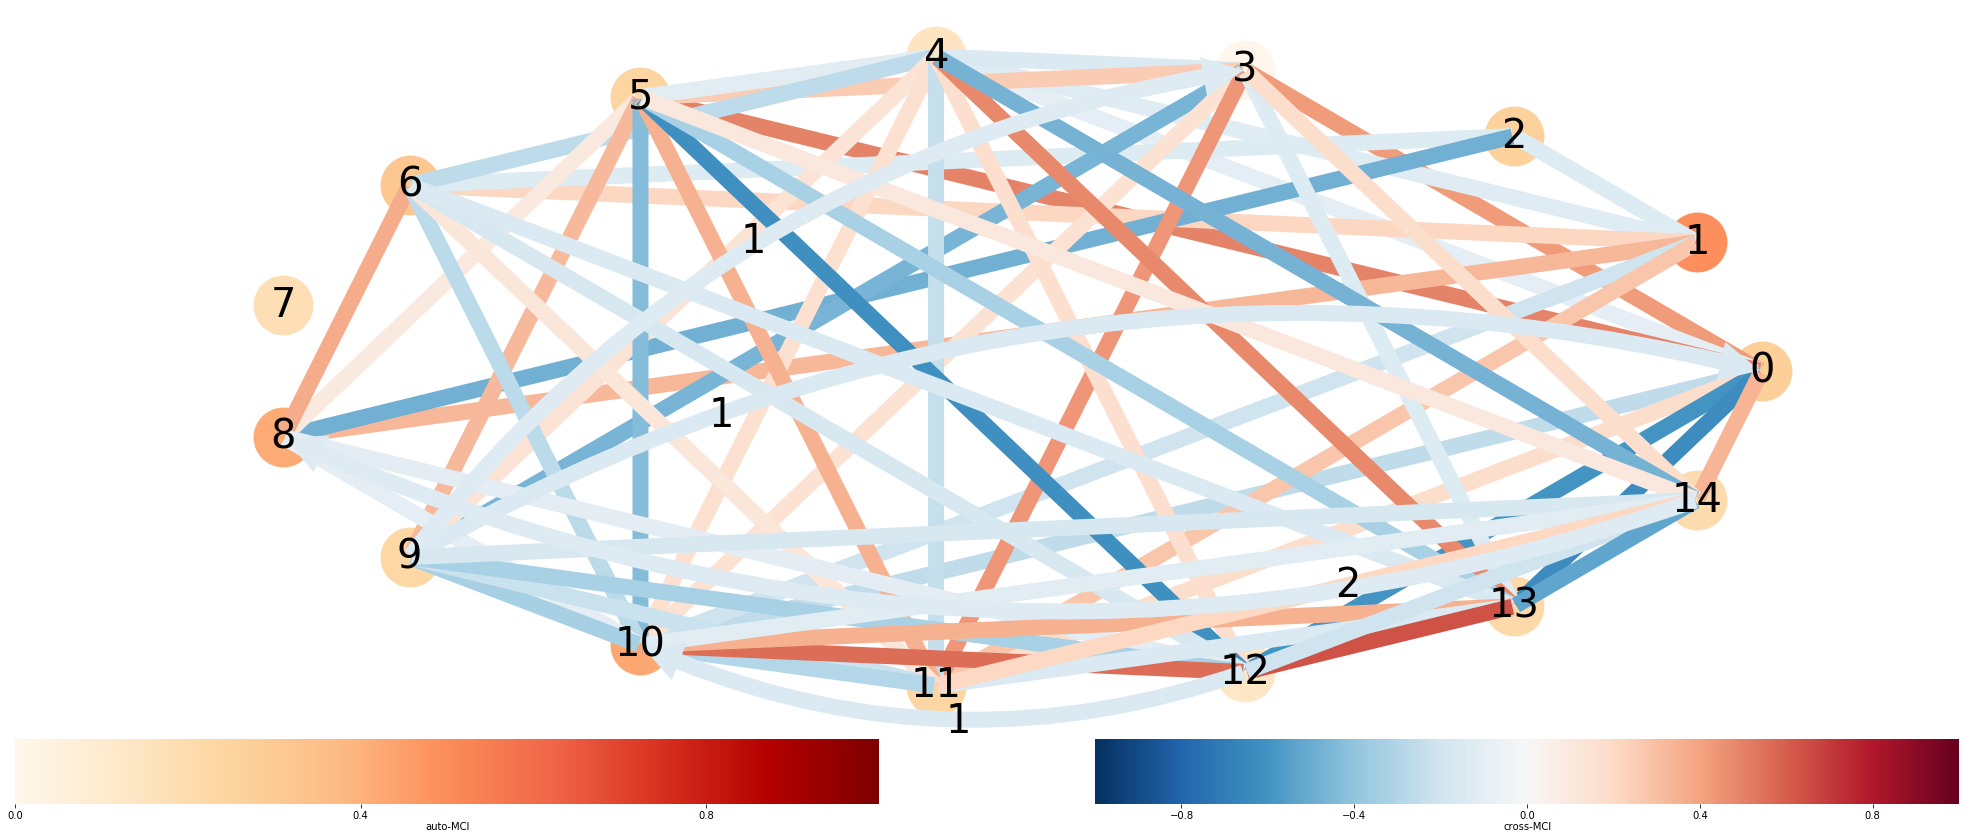

In [136]:
tp.plot_graph(
    val_matrix=results['val_matrix'],
    link_matrix=link_matrix,
    link_colorbar_label='cross-MCI',
    node_colorbar_label='auto-MCI',figsize=(30,15),
    node_label_size=40,
    link_label_fontsize = 40,
    node_size = 60,
    arrow_linewidth = 80
    )

In [14]:
#temp = pf.deseasonalize(np.transpose(result))
temp = np.array(result_air)
#temp = pf.deseasonalize(result)
clustering_air = AgglomerativeClustering(n_clusters=n_components).fit(np.transpose(temp))

In [17]:
clusters_air = clustering_air.labels_

In [15]:
df_air = pd.DataFrame({"lons":lon_list_air,"lats":lat_list_air,"clusters":clustering_air.labels_})

lon_temp = df_air["lons"].values
lon_temp[lon_temp > 180] = lon_temp[lon_temp > 180] -360
df_air["lons"] = lon_temp

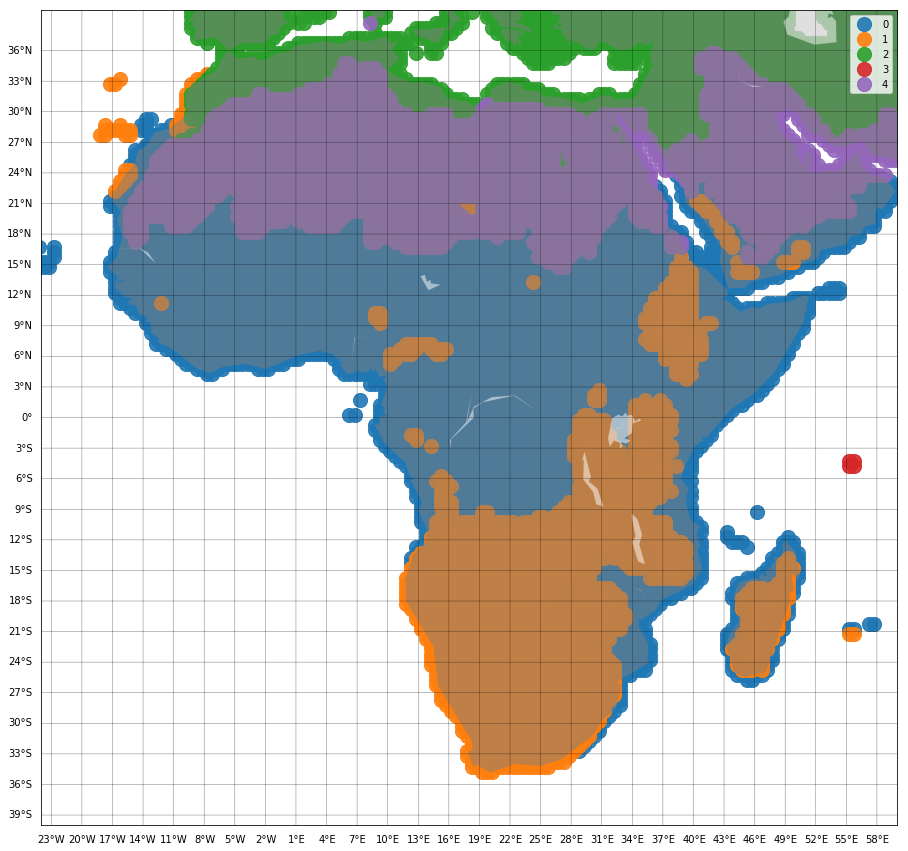

In [18]:
df_list = []
for j in range(len(set(clusters_air))):
    df_list.append(pd.DataFrame(columns=df_air.columns))

#lon = np.arange(-23.75,60.0,2.5)

fig, ax = plt.subplots(figsize=(30,15))
#fig = plt.figure(figsize=(30,15))
#ax = fig.add_subplot(111)
m = Basemap(llcrnrlon=-24, llcrnrlat=-40,urcrnrlon=60,urcrnrlat=40)
m.fillcontinents(color='grey', alpha=0.5)
m.drawparallels(np.arange(int(-39.75),int(39.75),3),labels=[1,0,0,0],linewidth=0.5)
m.drawmeridians(np.arange(int(-29.75),int(59.75),3),labels=[0,0,0,1],linewidth=0.5)
#m.drawcoastlines()
#colors = pf.random_color_1(n_components)

i = 0
for j in set(clusters_air):
    values = df_air["clusters"].values  
    Idx = np.where(values == j)[0]
    df_list[i] = df_air.iloc[Idx,:]
    df_list[i]["values"] = values[Idx]

    lons = df_list[i]["lons"].values
    lats = df_list[i]["lats"].values
    x,y = m(lons, lats)
    ax.scatter(x, y, alpha=0.9, s=200, label = i)
    i+=1

    
plt.legend()
plt.show()

In [ ]:
data = np.zeros((result_air.shape[0],result_air.shape[1],2))

N = result_air.shape[1]

for i in range(len(air_list)):
    if air_list[i] in pre_list:
        j = pre_list.index(air_list[i])
        data[:,i,1] = np.squeeze(result_air[:,i] - 273.15)
        data[:,i,0] = np.squeeze(result[:,j])

In [41]:
air_list = list(zip(lon_list_air,lat_list_air))

In [42]:
pre_list = list(zip(lon_list,lat_list))

In [43]:
clean_list = []
index = []
for i in range(len(air_list)):
    temp = neighbour_average(pre_list,pd.DataFrame(result),air_list[i][0], air_list[i][1])
    if temp.shape:
    #if not np.isnan(temp):
        clean_list.append(temp)
        index.append(i)
    #data[:,i,1] = np.squeeze(result_air[:,i])
    #data[:,i,0] = neighbour_average(pre_list,pd.DataFrame(result),air_list[i][0], air_list[i][1])

# First Version:

In [22]:
data = np.zeros((result_air.shape[0],len(clean_list),2))

for i in range(len(clean_list)):

    data[:,i,1] = np.squeeze(result_air[:,index[i]])
    data[:,i,0] = clean_list[i]

In [23]:
distance = np.zeros((data.shape[1],data.shape[1]))

In [24]:
for i in range(data.shape[1]):
    for j in range(data.shape[1]):
        distance[i,j] = LA.norm(data[:,i,:]-data[:,j,:])

In [25]:
clustering = AgglomerativeClustering(n_clusters=15,affinity="precomputed",linkage="complete").fit(distance)

In [26]:
clusters_air = np.zeros(len(lon_list_air))
clusters_air.fill(-1)

In [27]:
clusters_air[index] = clustering.labels_ 

In [28]:
index = np.argwhere(clusters_air == -1)

clusters_air = np.delete(clusters_air, index)
lat_list_air = np.delete(lat_list_air, index)
lon_list_air = np.delete(lon_list_air, index)

df_air = pd.DataFrame({"lons":lon_list_air,"lats":lat_list_air,"clusters":clusters_air})

lon_temp = df_air["lons"].values
lon_temp[lon_temp > 180] = lon_temp[lon_temp > 180] -360
df_air["lons"] = lon_temp

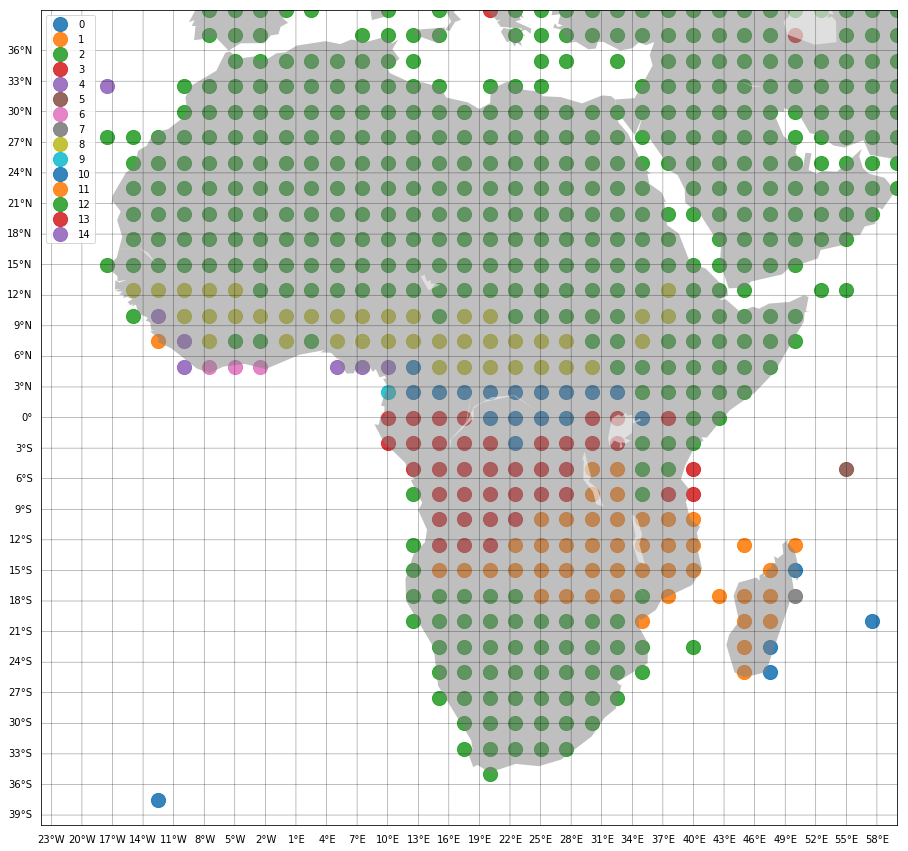

In [29]:
df_list = []
for j in range(len(set(clusters_air))):
    df_list.append(pd.DataFrame(columns=df_air.columns))

#lon = np.arange(-23.75,60.0,2.5)

fig, ax = plt.subplots(figsize=(30,15))
#fig = plt.figure(figsize=(30,15))
#ax = fig.add_subplot(111)
m = Basemap(llcrnrlon=-24, llcrnrlat=-40,urcrnrlon=60,urcrnrlat=40)
m.fillcontinents(color='grey', alpha=0.5)
m.drawparallels(np.arange(int(-39.75),int(39.75),3),labels=[1,0,0,0],linewidth=0.5)
m.drawmeridians(np.arange(int(-29.75),int(59.75),3),labels=[0,0,0,1],linewidth=0.5)
#m.drawcoastlines()
#colors = pf.random_color_1(n_components)

i = 0
for j in set(clusters_air):
    values = df_air["clusters"].values  
    Idx = np.where(values == j)[0]
    df_list[i] = df_air.iloc[Idx,:]
    df_list[i]["values"] = values[Idx]

    lons = df_list[i]["lons"].values
    lats = df_list[i]["lats"].values
    x,y = m(lons, lats)
    ax.scatter(x, y, alpha=0.9, s=200, label = i)
    i+=1

    
plt.legend()
plt.show()

# Second Version

In [56]:
air_list = list(zip(lon_list_air,lat_list_air))

pre_list = list(zip(lon_list,lat_list))

clean_list = []
Idx = []
for i in range(len(air_list)):
    temp = neighbour_average(pre_list,pd.DataFrame(result),air_list[i][0], air_list[i][1])
    if temp.shape:
    #if not np.isnan(temp):
        clean_list.append(temp)
        Idx.append(i)
    #data[:,i,1] = np.squeeze(result_air[:,i])
    #data[:,i,0] = neighbour_average(pre_list,pd.DataFrame(result),air_list[i][0], air_list[i][1])

In [57]:
precipitation = np.array(clean_list)/np.array(clean_list).std()
precipitation = pd.DataFrame(np.transpose(precipitation))

In [58]:
result_air = pd.DataFrame(result_air)
temperature = result_air.iloc[:,Idx]

In [59]:
temperature = temperature/temperature.stack().std()

In [60]:
precipitation.columns = temperature.columns

In [61]:
combined_vertically = pd.concat([temperature,precipitation],ignore_index=True,sort=False, axis=0)

In [171]:
data = np.zeros((result_air.shape[0] * 2,len(clean_list)))
result = pd.DataFrame(result_air)
first = result.iloc[:,index].values
for i in range(len(clean_list)):
    first = result.iloc[:,i].values
    second = clean_list[i,:]
    first /= first.std()
    second /= second.std()
    data[:,i] = np.array(list(first) + list(second))

In [62]:
#temp = pf.deseasonalize(np.transpose(result))
#temp = np.array(data)
#temp = pf.deseasonalize(result)
clustering = AgglomerativeClustering(n_clusters=5).fit(combined_vertically.transpose())

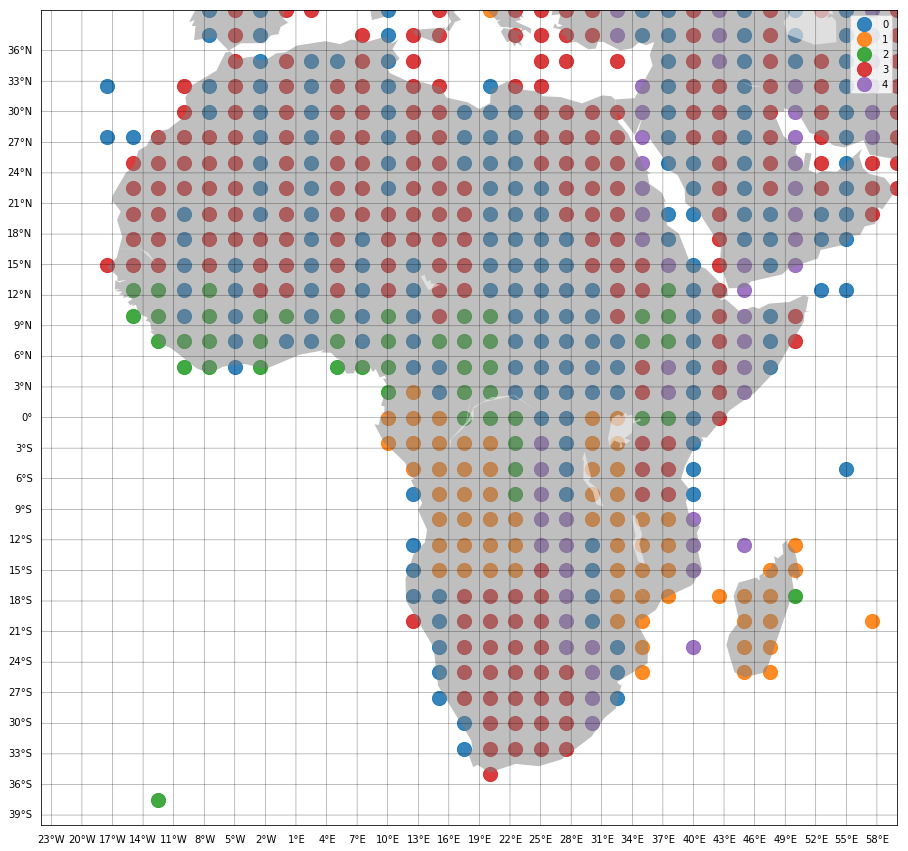

In [63]:
clusters_air = np.zeros(len(lon_list_air))
clusters_air.fill(-1)

clusters_air[Idx] = clustering.labels_ 

index = np.argwhere(clusters_air == -1)

clusters_air = np.delete(clusters_air, index)
lat_list_air = np.delete(lat_list_air, index)
lon_list_air = np.delete(lon_list_air, index)

df_air = pd.DataFrame({"lons":lon_list_air,"lats":lat_list_air,"clusters":clusters_air})

lon_temp = df_air["lons"].values
lon_temp[lon_temp > 180] = lon_temp[lon_temp > 180] -360
df_air["lons"] = lon_temp

df_list = []
for j in range(len(set(clusters_air))):
    df_list.append(pd.DataFrame(columns=df_air.columns))

#lon = np.arange(-23.75,60.0,2.5)

fig, ax = plt.subplots(figsize=(30,15))
#fig = plt.figure(figsize=(30,15))
#ax = fig.add_subplot(111)
m = Basemap(llcrnrlon=-24, llcrnrlat=-40,urcrnrlon=60,urcrnrlat=40)
m.fillcontinents(color='grey', alpha=0.5)
m.drawparallels(np.arange(int(-39.75),int(39.75),3),labels=[1,0,0,0],linewidth=0.5)
m.drawmeridians(np.arange(int(-29.75),int(59.75),3),labels=[0,0,0,1],linewidth=0.5)
#m.drawcoastlines()
#colors = pf.random_color_1(n_components)

i = 0
for j in set(clusters_air):
    values = df_air["clusters"].values  
    Idx = np.where(values == j)[0]
    df_list[i] = df_air.iloc[Idx,:]
    df_list[i]["values"] = values[Idx]

    lons = df_list[i]["lons"].values
    lats = df_list[i]["lats"].values
    x,y = m(lons, lats)
    ax.scatter(x, y, alpha=0.9, s=200, label = i)
    i+=1

    
plt.legend()
plt.show()

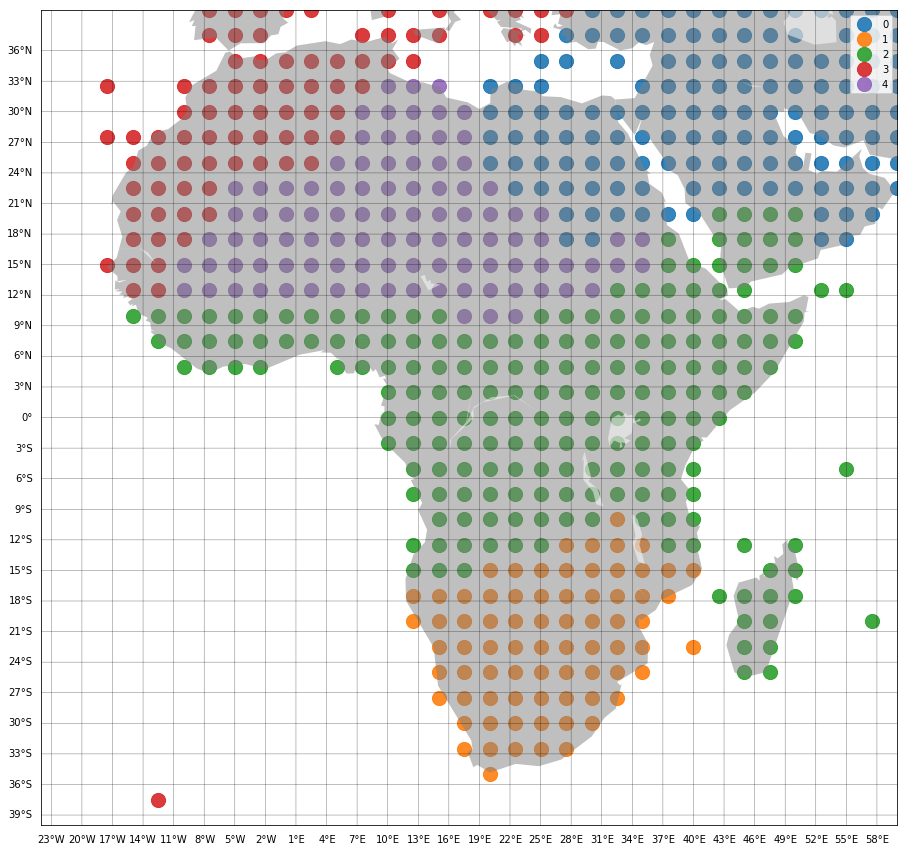

In [59]:
clusters_air = np.zeros(len(lon_list_air))
clusters_air.fill(-1)

clusters_air[Idx] = clustering.labels_ 

index = np.argwhere(clusters_air == -1)

clusters_air = np.delete(clusters_air, index)
lat_list_air = np.delete(lat_list_air, index)
lon_list_air = np.delete(lon_list_air, index)

df_air = pd.DataFrame({"lons":lon_list_air,"lats":lat_list_air,"clusters":clusters_air})

lon_temp = df_air["lons"].values
lon_temp[lon_temp > 180] = lon_temp[lon_temp > 180] -360
df_air["lons"] = lon_temp

df_list = []
for j in range(len(set(clusters_air))):
    df_list.append(pd.DataFrame(columns=df_air.columns))

#lon = np.arange(-23.75,60.0,2.5)

fig, ax = plt.subplots(figsize=(30,15))
#fig = plt.figure(figsize=(30,15))
#ax = fig.add_subplot(111)
m = Basemap(llcrnrlon=-24, llcrnrlat=-40,urcrnrlon=60,urcrnrlat=40)
m.fillcontinents(color='grey', alpha=0.5)
m.drawparallels(np.arange(int(-39.75),int(39.75),3),labels=[1,0,0,0],linewidth=0.5)
m.drawmeridians(np.arange(int(-29.75),int(59.75),3),labels=[0,0,0,1],linewidth=0.5)
#m.drawcoastlines()
#colors = pf.random_color_1(n_components)

i = 0
for j in set(clusters_air):
    values = df_air["clusters"].values  
    Idx = np.where(values == j)[0]
    df_list[i] = df_air.iloc[Idx,:]
    df_list[i]["values"] = values[Idx]

    lons = df_list[i]["lons"].values
    lats = df_list[i]["lats"].values
    x,y = m(lons, lats)
    ax.scatter(x, y, alpha=0.9, s=200, label = i)
    i+=1

    
plt.legend()
plt.show()

In [277]:
cluster_data = []
for i in range(n_components):
    Idx = np.where((df_air.clusters == i).values)[0]
    r = result[:,Idx]
    #r = pf.deseasonalize(np.array(r))
    data = pd.DataFrame(r)
    scale = StandardScaler()
    scaled_data = scale.fit_transform(data)
    pca = PCA(n_components=n_components)
    pca_model = pca.fit(scaled_data)
    pca_data = pca_model.transform(data)
    cluster_data.append(pca_data[:,0])

df_cluster = pd.DataFrame(np.transpose(np.matrix(cluster_data)))

In [52]:
cluster_data = []
for i in range(n_components):
    Idx = np.where((df_air.clusters == i).values)[0]
    temp = temperature.iloc[:,Idx]
    pre = precipitation.iloc[:,Idx]
    #r = pf.deseasonalize(np.array(r))
    combined_horizontally = pd.concat([temp,pre],ignore_index=True,sort=False, axis=1)
    scale = StandardScaler()
    scaled_data = scale.fit_transform(combined_horizontally)
    pca = PCA(n_components=n_components)
    pca_model = pca.fit(scaled_data)
    #print(pca_model.explained_variance_ratio_[0])
    pca_data = pca_model.transform(combined_horizontally)
    cluster_data.append(pca_data[:,0])

df_cluster = pd.DataFrame(np.transpose(np.matrix(cluster_data)))

In [53]:
df_cluster

0          1         2          3          4
0    26.716413   8.807068 -7.726505  -9.596606 -26.210198
1    23.745345   8.602925 -7.877650 -11.109390 -30.363576
2    23.784784  10.188236 -6.889619 -11.692042 -33.343005
3    16.353373   9.937492 -4.986229 -16.323541 -40.602769
4    12.327790   3.943645 -3.224294 -23.124211 -44.106870
..         ...        ...       ...        ...        ...
812  12.678161   2.348101 -1.603799 -25.832025 -45.455672
813  15.063120   7.073794 -1.281526 -21.315841 -41.237192
814  18.814404  13.598173 -5.939408 -14.179298 -32.654971
815  25.079144  12.267530 -8.448399  -9.562395 -25.848150
816  29.315630  10.365380 -7.843285  -9.846292 -27.205531

[817 rows x 5 columns]

In [62]:
var_names = df_cluster.columns

#pca_data = pca_model.transform(data)
#pca_data = result.dot(loading)
pca_data = np.matrix(df_cluster)

dataframe = pp.DataFrame(pca_data,var_names=var_names)
cond_ind_test = ParCorr()
pcmci = PCMCI(dataframe=dataframe, cond_ind_test=cond_ind_test)

In [88]:
results = pcmci.run_pcmci(tau_max=12, pc_alpha=None)
pcmci.print_significant_links(p_matrix=results['p_matrix'],
                                     val_matrix=results['val_matrix'],
                                     alpha_level=0.05)

link_matrix = pcmci.return_significant_parents(pq_matrix=results['p_matrix'],
                        val_matrix=results['val_matrix'], alpha_level=0.05)['link_matrix']



## Significant links at alpha = 0.05:

    Variable 0 has 10 link(s):
        (4 0): pval = 0.00000 | val = -0.504
        (0 -1): pval = 0.00000 | val = 0.280
        (2 0): pval = 0.00050 | val = -0.125
        (3 -1): pval = 0.00240 | val = -0.109
        (0 -10): pval = 0.00835 | val = 0.095
        (3 -10): pval = 0.01115 | val = -0.091
        (0 -4): pval = 0.01246 | val = 0.090
        (1 -4): pval = 0.01371 | val = 0.089
        (3 0): pval = 0.02655 | val = -0.080
        (0 -12): pval = 0.03482 | val = -0.076

    Variable 1 has 4 link(s):
        (2 0): pval = 0.00000 | val = -0.314
        (1 -1): pval = 0.00000 | val = 0.306
        (1 -11): pval = 0.00410 | val = 0.103
        (2 -2): pval = 0.02517 | val = -0.081

    Variable 2 has 12 link(s):
        (2 -1): pval = 0.00000 | val = 0.503
        (1 0): pval = 0.00000 | val = -0.314
        (4 0): pval = 0.00000 | val = 0.237
        (2 -2): pval = 0.00000 | val = 0.200
        (0 0): pval = 0.00050 | val = -0.125
    

(<Figure size 2160x1080 with 3 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fa7a7223198>)

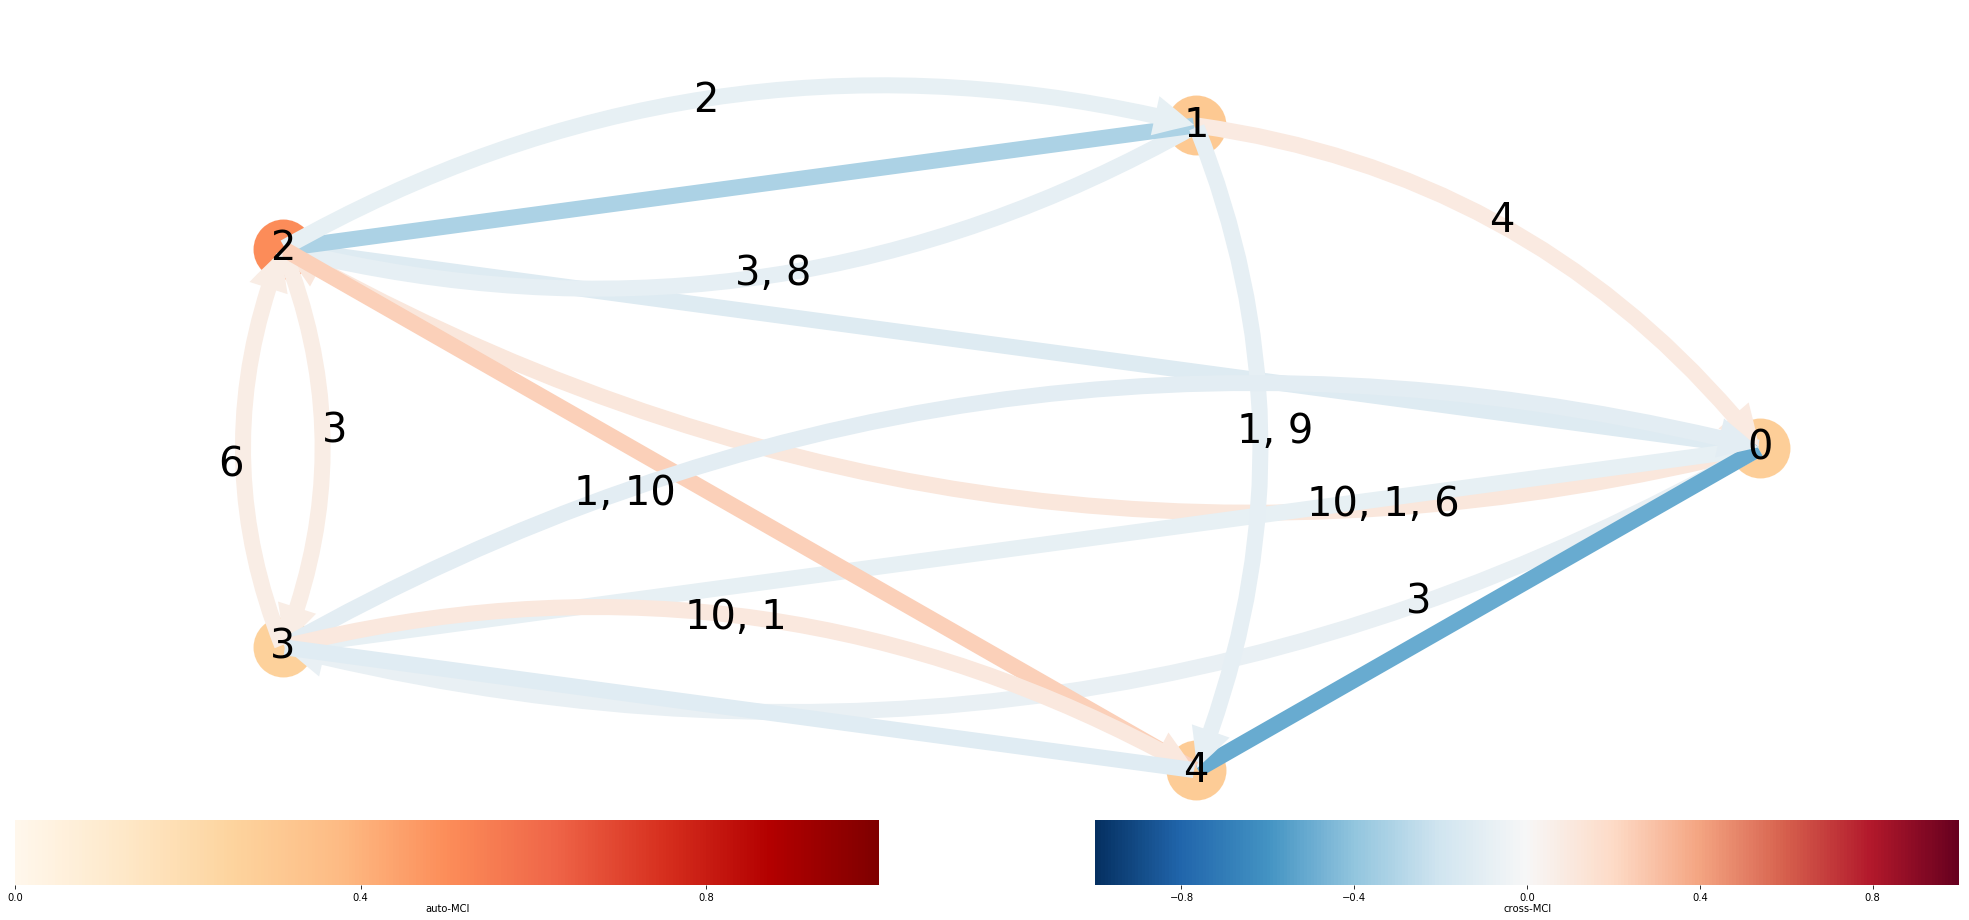

In [89]:
tp.plot_graph(
    val_matrix=results['val_matrix'],
    link_matrix=link_matrix,
    link_colorbar_label='cross-MCI',
    node_colorbar_label='auto-MCI',figsize=(30,15),
    node_label_size=40,
    link_label_fontsize = 40,
    node_size = 60,
    arrow_linewidth = 80
    )


In [90]:
q_matrix = pcmci.get_corrected_pvalues(p_matrix=results['p_matrix'], fdr_method='fdr_bh')
pcmci.print_significant_links(
        p_matrix = results['p_matrix'], 
        q_matrix = q_matrix,
        val_matrix = results['val_matrix'],
        alpha_level = 0.01)

link_matrix = pcmci.return_significant_parents(pq_matrix=q_matrix,
                        val_matrix=results['val_matrix'], alpha_level=0.01)['link_matrix']


## Significant links at alpha = 0.01:

    Variable 0 has 3 link(s):
        (4 0): pval = 0.00000 | qval = 0.00000 | val = -0.504
        (0 -1): pval = 0.00000 | qval = 0.00000 | val = 0.280
        (2 0): pval = 0.00050 | qval = 0.00050 | val = -0.125

    Variable 1 has 2 link(s):
        (2 0): pval = 0.00000 | qval = 0.00000 | val = -0.314
        (1 -1): pval = 0.00000 | qval = 0.00000 | val = 0.306

    Variable 2 has 5 link(s):
        (2 -1): pval = 0.00000 | qval = 0.00000 | val = 0.503
        (1 0): pval = 0.00000 | qval = 0.00000 | val = -0.314
        (4 0): pval = 0.00000 | qval = 0.00000 | val = 0.237
        (2 -2): pval = 0.00000 | qval = 0.00000 | val = 0.200
        (0 0): pval = 0.00050 | qval = 0.00050 | val = -0.125

    Variable 3 has 2 link(s):
        (3 -1): pval = 0.00000 | qval = 0.00000 | val = 0.268
        (4 0): pval = 0.00061 | qval = 0.00061 | val = -0.123

    Variable 4 has 4 link(s):
        (0 0): pval = 0.00000 | qval = 0.00000 | val = -0.504
 

(<Figure size 2160x1080 with 3 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fa7a70eb7f0>)

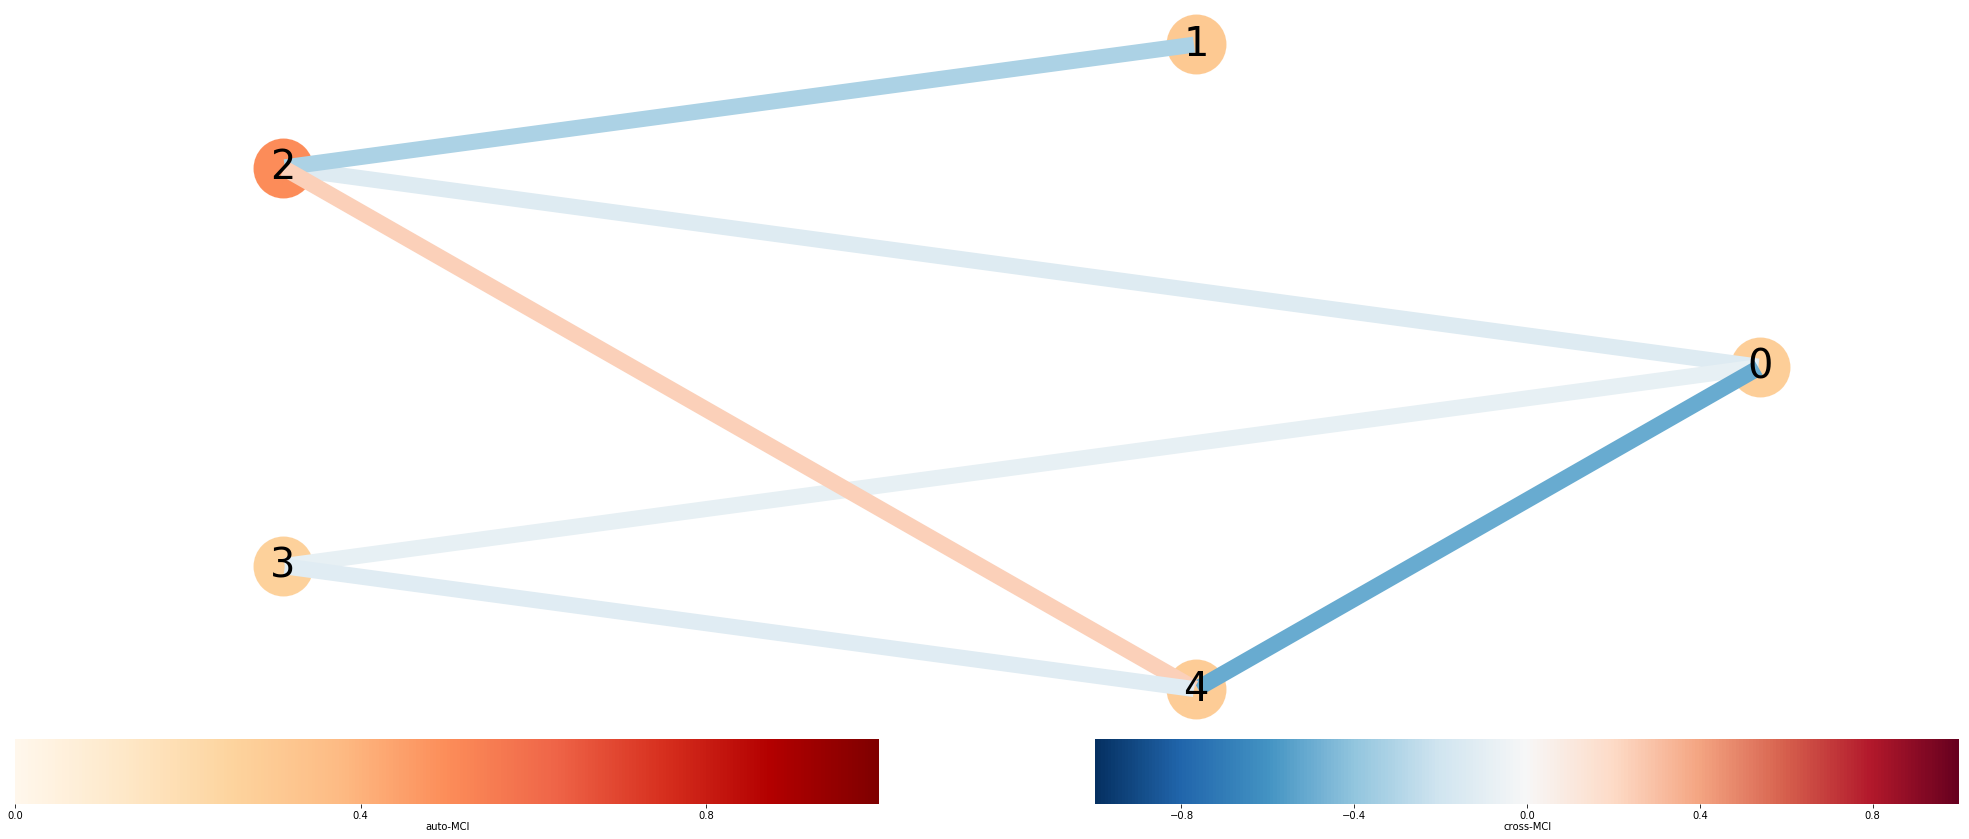

In [87]:
tp.plot_graph(
    val_matrix=results['val_matrix'],
    link_matrix=link_matrix,
    link_colorbar_label='cross-MCI',
    node_colorbar_label='auto-MCI',figsize=(30,15),
    node_label_size=40,
    link_label_fontsize = 40,
    node_size = 60,
    arrow_linewidth = 80
    )

In [ ]:
lon1 = np.arange(-40,60.0,2.5)

deg = np.zeros((len(lat_air),len(lon1)))

lat_number = deg.shape[0]
lon_number = deg.shape[1]

for i in range(lat_number):
    for j in range(lon_number):
        if not df_air[(df_air.lats == lat_air[i]) & (df_air.lons == lon1[j])].clusters.values.size == 0:
            
            deg[i,j] = df_air[(df_air.lats == lat_air[i]) & (df_air.lons == lon1[j])].clusters.values
        else:
            deg[i,j]=np.nan

In [61]:
air_list[726]

(25.0, 40.0)

In [64]:
air_list.index((22.5, -30))

721

In [68]:
neighbour_average(pre_list,pd.DataFrame(result),22.5, -30)

(-30.25, 22.25)
(-30.25, 22.5)
(-30.25, 22.75)
(-30, 22.25)
(-30, 22.75)
(-29.75, 22.25)
(-29.75, 22.5)
(-29.75, 22.75)


nan

In [60]:
index

[396,
 397,
 398,
 399,
 400,
 401,
 402,
 403,
 404,
 405,
 406,
 407,
 408,
 429,
 430,
 431,
 432,
 433,
 434,
 435,
 436,
 437,
 438,
 439,
 440,
 441,
 462,
 463,
 464,
 465,
 466,
 467,
 468,
 469,
 470,
 471,
 472,
 473,
 474,
 475,
 476,
 495,
 496,
 497,
 498,
 499,
 500,
 501,
 502,
 503,
 504,
 505,
 506,
 507,
 508,
 509,
 510,
 511,
 528,
 529,
 530,
 531,
 532,
 533,
 534,
 535,
 536,
 537,
 538,
 539,
 540,
 541,
 542,
 543,
 544,
 561,
 562,
 563,
 564,
 565,
 566,
 567,
 568,
 569,
 570,
 571,
 572,
 573,
 574,
 575,
 576,
 577,
 594,
 595,
 596,
 597,
 598,
 599,
 600,
 601,
 602,
 603,
 604,
 605,
 606,
 607,
 608,
 609,
 610,
 628,
 629,
 630,
 631,
 632,
 633,
 634,
 635,
 636,
 637,
 638,
 639,
 640,
 641,
 642,
 643,
 660,
 661,
 662,
 663,
 664,
 665,
 666,
 667,
 668,
 669,
 670,
 671,
 672,
 673,
 674,
 675,
 676,
 693,
 695,
 696,
 697,
 698,
 699,
 700,
 701,
 702,
 703,
 704,
 705,
 706,
 707,
 708,
 709,
 726,
 727,
 728,
 729,
 730,
 731,
 732,
 733,
 734

In [273]:
(22.5,12.5) in air_list

True

In [270]:
air_list

[(330.0, 40.0),
 (330.0, 37.5),
 (330.0, 35.0),
 (330.0, 32.5),
 (330.0, 30.0),
 (330.0, 27.5),
 (330.0, 25.0),
 (330.0, 22.5),
 (330.0, 20.0),
 (330.0, 17.5),
 (330.0, 15.0),
 (330.0, 12.5),
 (330.0, 10.0),
 (330.0, 7.5),
 (330.0, 5.0),
 (330.0, 2.5),
 (330.0, 0.0),
 (330.0, -2.5),
 (330.0, -5.0),
 (330.0, -7.5),
 (330.0, -10.0),
 (330.0, -12.5),
 (330.0, -15.0),
 (330.0, -17.5),
 (330.0, -20.0),
 (330.0, -22.5),
 (330.0, -25.0),
 (330.0, -27.5),
 (330.0, -30.0),
 (330.0, -32.5),
 (330.0, -35.0),
 (330.0, -37.5),
 (330.0, -40.0),
 (332.5, 40.0),
 (332.5, 37.5),
 (332.5, 35.0),
 (332.5, 32.5),
 (332.5, 30.0),
 (332.5, 27.5),
 (332.5, 25.0),
 (332.5, 22.5),
 (332.5, 20.0),
 (332.5, 17.5),
 (332.5, 15.0),
 (332.5, 12.5),
 (332.5, 10.0),
 (332.5, 7.5),
 (332.5, 5.0),
 (332.5, 2.5),
 (332.5, 0.0),
 (332.5, -2.5),
 (332.5, -5.0),
 (332.5, -7.5),
 (332.5, -10.0),
 (332.5, -12.5),
 (332.5, -15.0),
 (332.5, -17.5),
 (332.5, -20.0),
 (332.5, -22.5),
 (332.5, -25.0),
 (332.5, -27.5),
 (332.5, -3

In [329]:
air_list.index((330.0, -25.0))

26

In [339]:
np.argwhere(np.isnan(data[:,:,0]))

array([[   0,    0],
       [   0,    1],
       [   0,    2],
       ...,
       [ 816, 1218],
       [ 816, 1219],
       [ 816, 1220]])

In [338]:
data[:,700,0]

array([0.00000000e+00, 2.06500006e+00, 1.95000008e-01, 2.10000008e-01,
       2.95000017e-01, 0.00000000e+00, 0.00000000e+00, 4.09999967e-01,
       9.99999978e-03, 1.02500007e-01, 0.00000000e+00, 1.24999993e-01,
       0.00000000e+00, 1.72499999e-01, 1.14249992e+00, 2.10000008e-01,
       1.61750007e+00, 0.00000000e+00, 8.74999985e-02, 4.17500019e-01,
       9.99999978e-03, 1.02500007e-01, 0.00000000e+00, 1.02749991e+00,
       0.00000000e+00, 3.52749991e+00, 1.95000008e-01, 2.10000008e-01,
       1.23000002e+00, 0.00000000e+00, 0.00000000e+00, 2.69500017e+00,
       2.49999985e-02, 1.02500007e-01, 0.00000000e+00, 1.24999993e-01,
       0.00000000e+00, 1.72499999e-01, 1.95000008e-01, 2.10000008e-01,
       3.92499983e-01, 0.00000000e+00, 0.00000000e+00, 2.49999994e-03,
       2.02500001e-01, 1.02500007e-01, 8.47499967e-01, 1.24999993e-01,
       0.00000000e+00, 1.72499999e-01, 1.95000008e-01, 2.10000008e-01,
       3.92499983e-01, 0.00000000e+00, 0.00000000e+00, 1.06949997e+01,
      

In [279]:
air_list.index((22.5,22.5))

700

In [301]:
data[:,700,0]

array([0.00000000e+00, 2.06500006e+00, 1.95000008e-01, 2.10000008e-01,
       2.95000017e-01, 0.00000000e+00, 0.00000000e+00, 4.09999967e-01,
       9.99999978e-03, 1.02500007e-01, 0.00000000e+00, 1.24999993e-01,
       0.00000000e+00, 1.72499999e-01, 1.14249992e+00, 2.10000008e-01,
       1.61750007e+00, 0.00000000e+00, 8.74999985e-02, 4.17500019e-01,
       9.99999978e-03, 1.02500007e-01, 0.00000000e+00, 1.02749991e+00,
       0.00000000e+00, 3.52749991e+00, 1.95000008e-01, 2.10000008e-01,
       1.23000002e+00, 0.00000000e+00, 0.00000000e+00, 2.69500017e+00,
       2.49999985e-02, 1.02500007e-01, 0.00000000e+00, 1.24999993e-01,
       0.00000000e+00, 1.72499999e-01, 1.95000008e-01, 2.10000008e-01,
       3.92499983e-01, 0.00000000e+00, 0.00000000e+00, 2.49999994e-03,
       2.02500001e-01, 1.02500007e-01, 8.47499967e-01, 1.24999993e-01,
       0.00000000e+00, 1.72499999e-01, 1.95000008e-01, 2.10000008e-01,
       3.92499983e-01, 0.00000000e+00, 0.00000000e+00, 1.06949997e+01,
      

In [348]:
r = neighbour_average(pre_list,pd.DataFrame(result),air_list[26][0], air_list[26][1])

In [350]:
np.isnan(r)

True

In [325]:
np.average(r,axis=0)

array([0.00000000e+00, 2.06500006e+00, 1.95000008e-01, 2.10000008e-01,
       2.95000017e-01, 0.00000000e+00, 0.00000000e+00, 4.09999967e-01,
       9.99999978e-03, 1.02500007e-01, 0.00000000e+00, 1.24999993e-01,
       0.00000000e+00, 1.72499999e-01, 1.14249992e+00, 2.10000008e-01,
       1.61750007e+00, 0.00000000e+00, 8.74999985e-02, 4.17500019e-01,
       9.99999978e-03, 1.02500007e-01, 0.00000000e+00, 1.02749991e+00,
       0.00000000e+00, 3.52749991e+00, 1.95000008e-01, 2.10000008e-01,
       1.23000002e+00, 0.00000000e+00, 0.00000000e+00, 2.69500017e+00,
       2.49999985e-02, 1.02500007e-01, 0.00000000e+00, 1.24999993e-01,
       0.00000000e+00, 1.72499999e-01, 1.95000008e-01, 2.10000008e-01,
       3.92499983e-01, 0.00000000e+00, 0.00000000e+00, 2.49999994e-03,
       2.02500001e-01, 1.02500007e-01, 8.47499967e-01, 1.24999993e-01,
       0.00000000e+00, 1.72499999e-01, 1.95000008e-01, 2.10000008e-01,
       3.92499983e-01, 0.00000000e+00, 0.00000000e+00, 1.06949997e+01,
      

In [316]:
pre_list.index((22.25,22.75))

6173

In [317]:
result[:,6173]

matrix([[0.000e+00],
        [2.060e+00],
        [2.200e-01],
        [2.400e-01],
        [3.000e-01],
        [0.000e+00],
        [0.000e+00],
        [3.500e-01],
        [1.000e-02],
        [1.200e-01],
        [0.000e+00],
        [1.600e-01],
        [0.000e+00],
        [1.700e-01],
        [1.160e+00],
        [2.400e-01],
        [1.530e+00],
        [0.000e+00],
        [7.000e-02],
        [3.500e-01],
        [1.000e-02],
        [1.200e-01],
        [0.000e+00],
        [1.000e+00],
        [0.000e+00],
        [3.400e+00],
        [2.200e-01],
        [2.400e-01],
        [1.260e+00],
        [0.000e+00],
        [0.000e+00],
        [2.250e+00],
        [1.000e-02],
        [1.200e-01],
        [0.000e+00],
        [1.600e-01],
        [0.000e+00],
        [1.700e-01],
        [2.200e-01],
        [2.400e-01],
        [4.000e-01],
        [0.000e+00],
        [0.000e+00],
        [0.000e+00],
        [1.500e-01],
        [1.200e-01],
        [8.700e-01],
        [1.60